In [2]:
import os
import sys
import sqlite3
import numpy as np
import pandas as pd
import seaborn as sns
import powerlaw as pl
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
import statsmodels.api as sm
from statsmodels.graphics import tsaplots
# add parent directory
sys.path.append('..\\..')
from src.utils import *

In [8]:
# show current databases in data folder
cwd = os.getcwd()
analysis_path = os.path.abspath(os.path.join(cwd, os.pardir))
parent_path = os.path.abspath(os.path.join(analysis_path, os.pardir))
data_path = f"{parent_path}\\data"
files = os.listdir(data_path)
print(f"databases = {files}")

databases = ['growth.db', 'growth2.db', 'nogrowth.db', 'nogrowth2.db', 'transition.db']


In [9]:
# load model parameters
params = load_parameters(f'{parent_path}\\src\\parameters.yml')
# analysis parameters
steps = params['simulation']['steps']
start = params['simulation']['start']*steps
end = (params['simulation']['start'] + params['simulation']['years'])*steps
middle = int(end/2)
years = np.linspace(0, params['simulation']['years'], params['simulation']['years']*steps)

In [10]:
# connect to sql database
# database index
index = 0
# get database name
database_name = files[index]
# create connection to database
con = sqlite3.connect(f"{data_path}\\{database_name}")
# create database cursor
cur = con.cursor()

In [11]:
# tables in database
tables = pd.read_sql_query(
    """
    SELECT 
        name
    FROM 
        sqlite_schema
    WHERE 
        type ='table' AND 
        name NOT LIKE 'sqlite_%';
    """,
    con
)
tables

,name
0,macro_data
1,firm_data
2,bank_data
3,household_data
4,node_data
5,edge_data


## Single Macro Analysis

In [12]:
# macro_results table 
macro = pd.read_sql_query(
    f"""
    SELECT * FROM macro_data
    WHERE simulation = 0
    ;
    """,
    con
)
macro

,simulation,time,consumption,nominal_consumption,investment,nominal_investment,real_gdp,nominal_gdp,capital,cfirm_productivity,...,bank_nhhi,bank_hpi,avg_loan_interest,avg_reserve_ratio,avg_capital_ratio,money_supply,bank_bankruptcy,bank_mean_degree,cfirm_mean_degree,kfirm_mean_degree
0,0,1,1594.519584,1614.654854,402.850562,407.166861,1997.370146,2021.821715,5082.850562,1.004955,...,0.007500,1.000000,0.019749,0.549029,0.063727,3.929846e+03,0.0,20.0,1.035,0.00
1,0,2,1436.752627,1455.683059,404.521277,415.123475,1841.273904,1870.806534,5360.300575,1.008575,...,0.007505,1.000000,0.019540,0.555534,0.067477,3.881785e+03,0.0,20.7,1.165,0.00
2,0,3,1448.532262,1469.398311,486.690631,505.736760,1935.222893,1975.135071,5712.305186,1.013468,...,0.007672,1.000000,0.019322,0.560249,0.071069,3.844713e+03,0.0,22.9,1.385,0.00
3,0,4,1459.711035,1483.955890,534.055474,561.748667,1993.766510,2045.704557,6099.917542,1.020236,...,0.008790,1.000000,0.019109,0.559618,0.073563,3.845919e+03,0.0,27.0,1.625,0.00
4,0,5,1448.675184,1476.984893,557.263895,591.905738,2005.939078,2068.890630,6494.323711,1.024973,...,0.009774,0.035885,0.018894,0.559584,0.075861,3.854338e+03,0.0,32.2,1.930,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0,596,40914.533854,547749.596356,8806.601428,78661.401408,49721.135281,626410.997763,345932.666454,25.031435,...,0.097912,0.139128,0.013545,0.623758,0.359778,1.841219e+06,0.0,124.2,6.025,0.94
596,0,597,41153.590409,553379.733449,8648.284183,77825.934639,49801.874592,631205.668088,345858.311233,25.229024,...,0.100074,0.134446,0.013552,0.618139,0.376778,1.867303e+06,0.0,123.2,6.015,0.94
597,0,598,41363.722742,558289.249204,8833.851640,80178.056776,50197.574382,638467.305980,344875.911448,25.377960,...,0.100504,0.149457,0.013547,0.618246,0.396856,1.876885e+06,0.0,124.8,5.990,0.94
598,0,599,41655.597003,564098.452194,8508.264296,77299.276097,50163.861300,641397.728291,345684.426812,25.487764,...,0.103044,0.144768,0.013511,0.614774,0.413165,1.890145e+06,0.0,124.4,6.040,0.96


In [13]:
# macro_results columns
macro.describe()

,simulation,time,consumption,nominal_consumption,investment,nominal_investment,real_gdp,nominal_gdp,capital,cfirm_productivity,...,bank_nhhi,bank_hpi,avg_loan_interest,avg_reserve_ratio,avg_capital_ratio,money_supply,bank_bankruptcy,bank_mean_degree,cfirm_mean_degree,kfirm_mean_degree
count,600.0,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,...,600.000000,600.000000,600.000000,600.000000,600.000000,6.000000e+02,600.000000,600.000000,600.000000,600.000000
mean,0.0,300.500000,11677.417538,94494.770143,2840.447001,14967.865727,14517.864540,109462.635869,102619.104102,7.439586,...,0.158347,0.166963,0.014579,0.583046,4.971917,3.515694e+05,0.276667,103.769000,4.996325,1.001133
std,0.0,173.349358,10462.829087,131585.168749,2498.767662,21179.757497,12919.427657,152486.614331,93243.766493,6.579682,...,0.100111,0.098328,0.000938,0.073934,19.004203,4.873799e+05,0.796563,20.573954,0.901666,0.780654
min,0.0,1.000000,1407.968477,1455.683059,149.304208,116.441880,1665.445647,1724.117535,5082.850562,1.004955,...,0.007500,0.024850,0.013411,0.412334,0.058251,3.844713e+03,0.000000,20.000000,1.035000,0.000000
25%,0.0,150.750000,3285.908657,6223.780452,1125.507629,1309.127152,4422.662945,7503.481215,33629.559527,2.190440,...,0.088589,0.114458,0.013969,0.519788,0.412153,1.674271e+04,0.000000,91.250000,4.445000,0.480000
50%,0.0,300.500000,7706.135241,29225.452298,1868.700332,4516.711768,9563.560686,33912.185495,68625.531219,4.902455,...,0.128180,0.145916,0.014371,0.590393,1.596430,1.088112e+05,0.000000,106.300000,5.090000,0.900000
75%,0.0,450.250000,17647.392208,131294.437579,4066.750446,20203.029720,21874.534549,151910.459890,161733.357946,11.035770,...,0.216241,0.181906,0.014902,0.636818,3.180418,5.419143e+05,0.000000,117.200000,5.591250,1.320000
max,0.0,600.000000,41936.363455,569494.788782,11037.909571,90583.934653,50806.743486,650970.853592,345932.666454,25.665847,...,0.466083,1.000000,0.019749,0.760711,336.880188,1.906742e+06,6.000000,144.800000,6.635000,3.600000


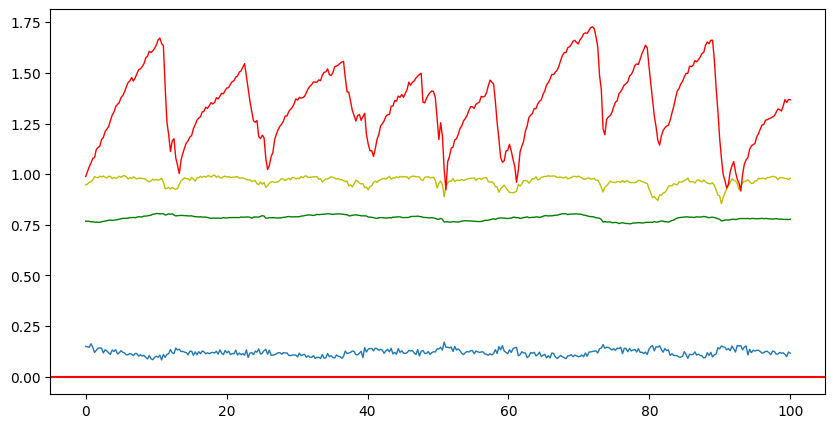

In [14]:
# output shares/ratios
debt_ratio = macro['debt']/macro['nominal_gdp']
profit_share = macro['profits']/macro['nominal_gdp']
wage_share = macro['wages']/macro['nominal_gdp']

plt.figure(figsize=(10,5))
plt.plot(years, 1 - macro['unemployment_rate'][start:], color='y', linewidth=1)
plt.plot(years, debt_ratio[start:], color='r', linewidth=1)
plt.plot(years, profit_share[start:], linewidth=1)
plt.plot(years, wage_share[start:], color='g', linewidth=1)
plt.axhline(0, color='r')
# save figure
plt.savefig(f"{parent_path}\\figures\\shares.png")
plt.show()

### Cyclical Autocorrelation

Text(0.5, 1.0, '')

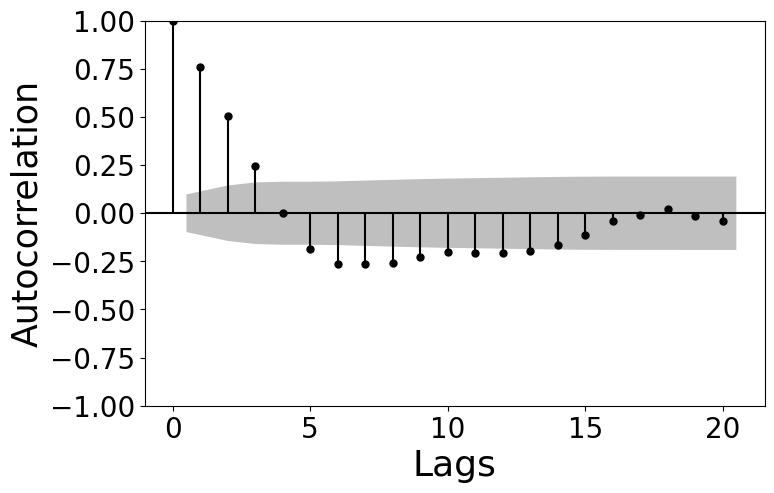

In [34]:
x = macro['real_gdp'][start:]
cycle, trend = sm.tsa.filters.hpfilter(x, 1600)

fig = plt.figure(figsize=(8,5))
ax1 = fig.add_subplot(111)

tsaplots.plot_acf(cycle, lags=20, ax=ax1, color='k', vlines_kwargs={"colors": 'k'})
for item in ax1.collections:
    if type(item)==PolyCollection:
        item.set_facecolor('k')

plt.xlabel("Lags", fontsize=26)
plt.ylabel("Autocorrelation", fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title("", fontsize=25)

Text(0.5, 1.0, '')

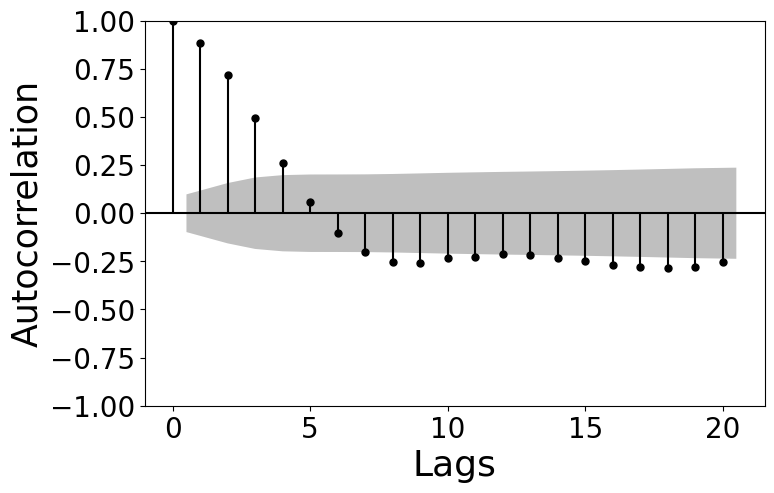

In [35]:
x = macro['consumption'][start:]
cycle, trend = sm.tsa.filters.hpfilter(x, 1600)

fig = plt.figure(figsize=(8,5))
ax1 = fig.add_subplot(111)

tsaplots.plot_acf(cycle, lags=20, ax=ax1, color='k', vlines_kwargs={"colors": 'k'})
for item in ax1.collections:
    if type(item)==PolyCollection:
        item.set_facecolor('k')

plt.xlabel("Lags", fontsize=26)
plt.ylabel("Autocorrelation", fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title("", fontsize=25)

Text(0.5, 1.0, '')

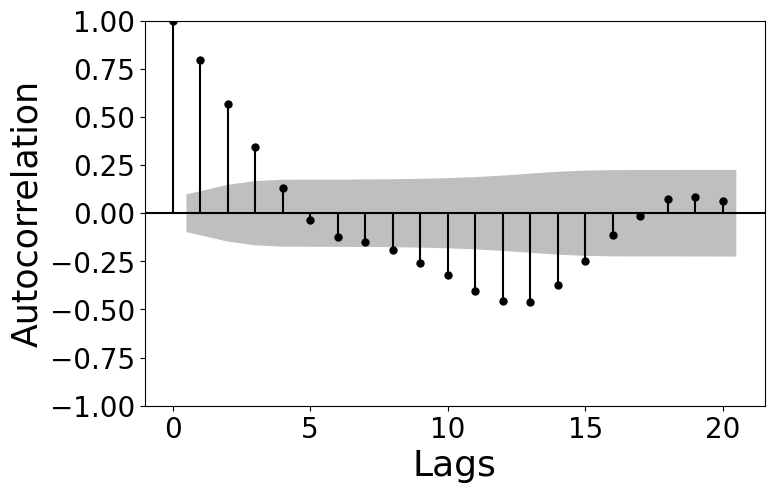

In [36]:
x = macro['investment'][start:]
cycle, trend = sm.tsa.filters.hpfilter(x, 1600)

fig = plt.figure(figsize=(8,5))
ax1 = fig.add_subplot(111)

tsaplots.plot_acf(cycle, lags=20, ax=ax1, color='k', vlines_kwargs={"colors": 'k'})
for item in ax1.collections:
    if type(item)==PolyCollection:
        item.set_facecolor('k')

plt.xlabel("Lags", fontsize=26)
plt.ylabel("Autocorrelation", fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title("", fontsize=25)

Text(0.5, 1.0, '')

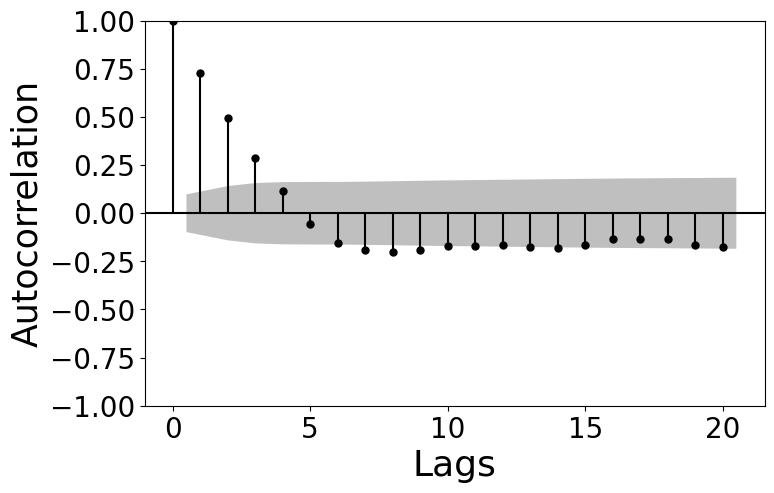

In [37]:
x = macro['unemployment_rate'][start:]
cycle, trend = sm.tsa.filters.hpfilter(x, 1600)

fig = plt.figure(figsize=(8,5))
ax1 = fig.add_subplot(111)

tsaplots.plot_acf(cycle, lags=20, ax=ax1, color='k', vlines_kwargs={"colors": 'k'})
for item in ax1.collections:
    if type(item)==PolyCollection:
        item.set_facecolor('k')

plt.xlabel("Lags", fontsize=26)
plt.ylabel("Autocorrelation", fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title("", fontsize=25)

Text(0.5, 1.0, '')

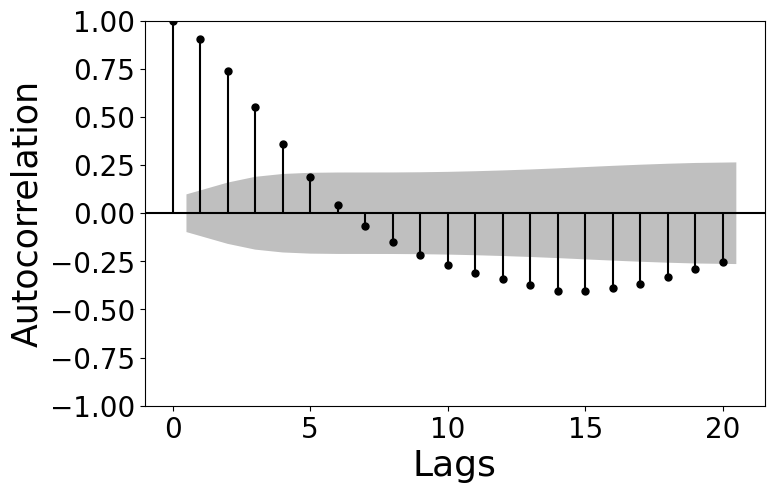

In [38]:
x = macro['debt'][start:]/macro['nominal_gdp'][start:]
cycle, trend = sm.tsa.filters.hpfilter(x, 1600)

fig = plt.figure(figsize=(8,5))
ax1 = fig.add_subplot(111)

tsaplots.plot_acf(cycle, lags=20, ax=ax1, color='k', vlines_kwargs={"colors": 'k'})
for item in ax1.collections:
    if type(item)==PolyCollection:
        item.set_facecolor('k')

plt.xlabel("Lags", fontsize=26)
plt.ylabel("Autocorrelation", fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title("", fontsize=25)

### Cyclical Cross Correlation

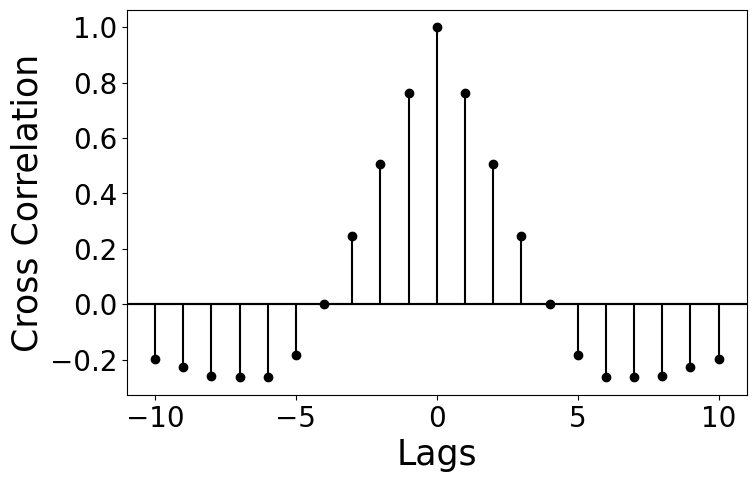

In [39]:
x = macro['real_gdp'][start:]
y = macro['real_gdp'][start:]

xcycle, xtrend = sm.tsa.filters.hpfilter(x, 1600)
ycycle, ytrend = sm.tsa.filters.hpfilter(y, 1600)

plt.figure(figsize=(8,5))
corr = plt.xcorr(xcycle, ycycle, color='k')
plt.scatter(corr[0], corr[1], color='k')
plt.axhline(0, color="k")
plt.xlabel("Lags", fontsize=25)
plt.ylabel("Cross Correlation", fontsize=25)
plt.xticks([-10, -5, 0, 5, 10], fontsize=20)
plt.yticks(fontsize=20)
plt.show()

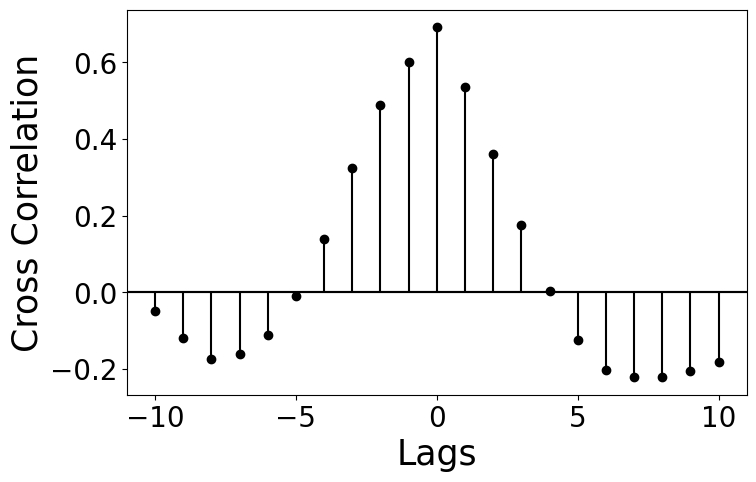

In [40]:
x = macro['real_gdp'][start:]
y = macro['consumption'][start:]

xcycle, xtrend = sm.tsa.filters.hpfilter(x, 1600)
ycycle, ytrend = sm.tsa.filters.hpfilter(y, 1600)

plt.figure(figsize=(8,5))
corr = plt.xcorr(xcycle, ycycle, color='k')
plt.scatter(corr[0], corr[1], color='k')
plt.axhline(0, color="k")
plt.xlabel("Lags", fontsize=25)
plt.ylabel("Cross Correlation", fontsize=25)
plt.xticks([-10, -5, 0, 5, 10], fontsize=20)
plt.yticks(fontsize=20)
plt.show()

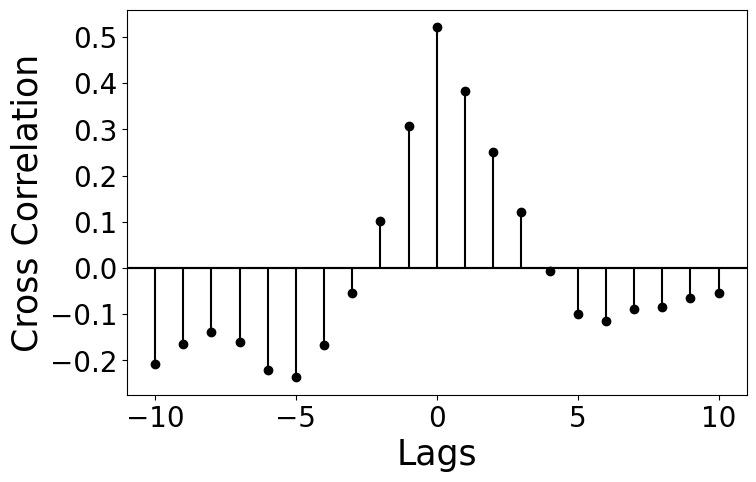

In [41]:
x = macro['real_gdp'][start:]
y = macro['investment'][start:]

xcycle, xtrend = sm.tsa.filters.hpfilter(x, 1600)
ycycle, ytrend = sm.tsa.filters.hpfilter(y, 1600)

plt.figure(figsize=(8,5))
corr = plt.xcorr(xcycle, ycycle, color='k')
plt.scatter(corr[0], corr[1], color='k')
plt.axhline(0, color="k")
plt.xlabel("Lags", fontsize=25)
plt.ylabel("Cross Correlation", fontsize=25)
plt.xticks([-10, -5, 0, 5, 10], fontsize=20)
plt.yticks(fontsize=20)
plt.show()

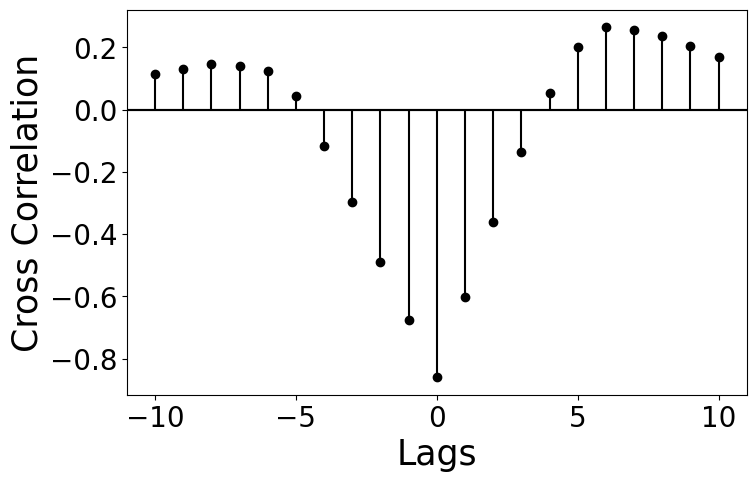

In [42]:
x = macro['real_gdp'][start:]
y = macro['unemployment_rate'][start:]

xcycle, xtrend = sm.tsa.filters.hpfilter(x, 1600)
ycycle, ytrend = sm.tsa.filters.hpfilter(y, 1600)

plt.figure(figsize=(8,5))
corr = plt.xcorr(xcycle, ycycle, color='k')
plt.scatter(corr[0], corr[1], color='k')
plt.axhline(0, color="k")
plt.xlabel("Lags", fontsize=25)
plt.ylabel("Cross Correlation", fontsize=25)
plt.xticks([-10, -5, 0, 5, 10], fontsize=20)
plt.yticks(fontsize=20)
plt.show()

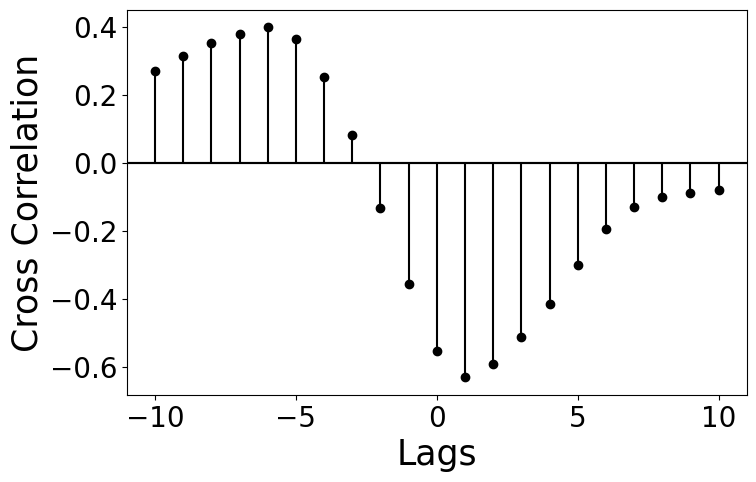

In [43]:
x = macro['debt'][start:]
y = macro['unemployment_rate'][start:]

xcycle, xtrend = sm.tsa.filters.hpfilter(x, 1600)
ycycle, ytrend = sm.tsa.filters.hpfilter(y, 1600)

plt.figure(figsize=(8,5))
corr = plt.xcorr(xcycle, ycycle, color='k')
plt.scatter(corr[0], corr[1], color='k')
plt.axhline(0, color="k")
plt.xlabel("Lags", fontsize=25)
plt.ylabel("Cross Correlation", fontsize=25)
plt.xticks([-10, -5, 0, 5, 10], fontsize=20)
plt.yticks(fontsize=20)
plt.show()

### Time Series

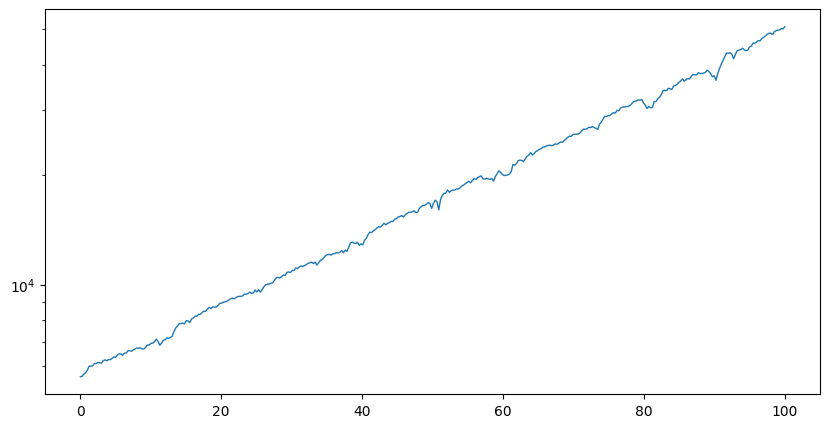

In [44]:
# real GDP
plt.figure(figsize=(10,5))
plt.plot(years, macro['real_gdp'][start:], linewidth=1)
plt.yscale('log')
plt.show()

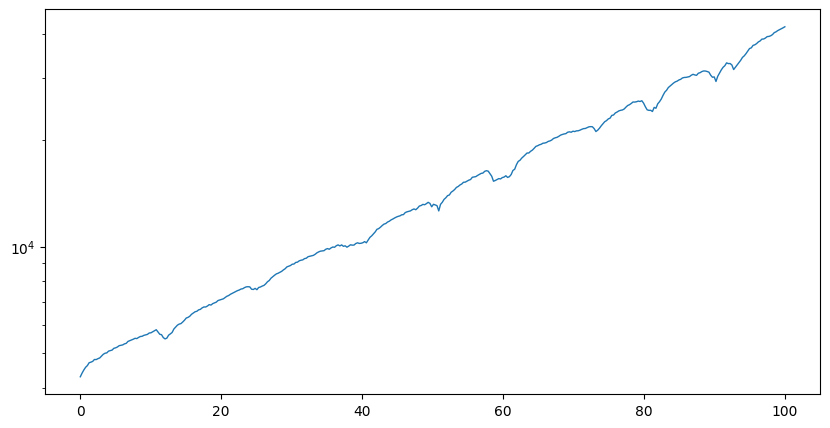

In [45]:
# consumption
plt.figure(figsize=(10,5))
plt.plot(years, macro['consumption'][start:], linewidth=1)
plt.yscale('log')
plt.show()

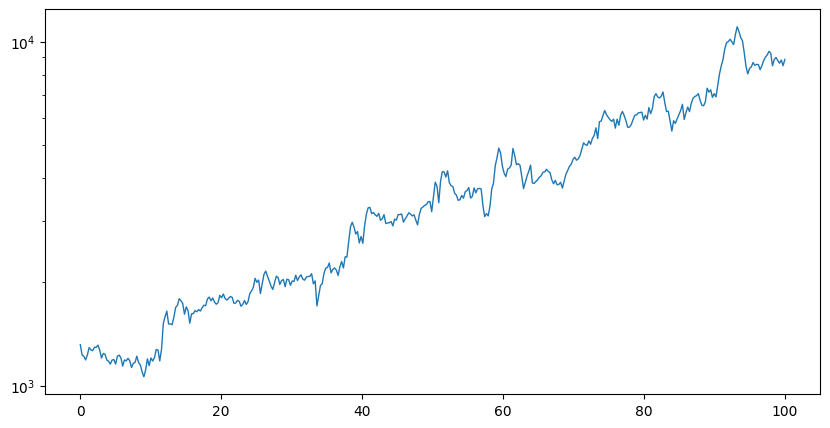

In [46]:
# investment
plt.figure(figsize=(10,5))
plt.plot(years, macro['investment'][start:], linewidth=1)
plt.yscale('log')
plt.show()

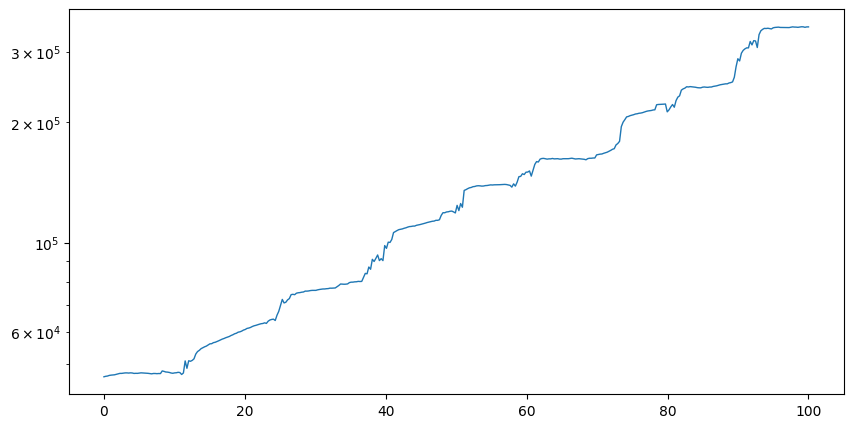

In [47]:
# capital
plt.figure(figsize=(10,5))
plt.plot(years, macro['capital'][start:], linewidth=1)
plt.yscale('log')
plt.show()

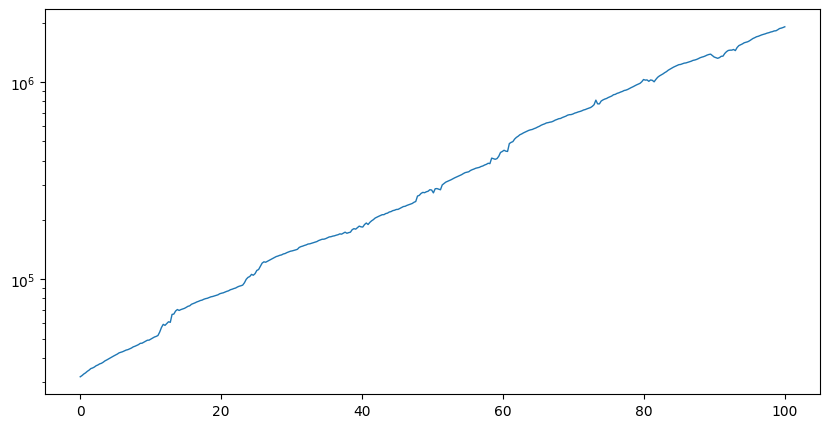

In [48]:
# money supply
plt.figure(figsize=(10,5))
plt.plot(years, macro['money_supply'][start:], linewidth=1)
plt.yscale('log')
plt.show()

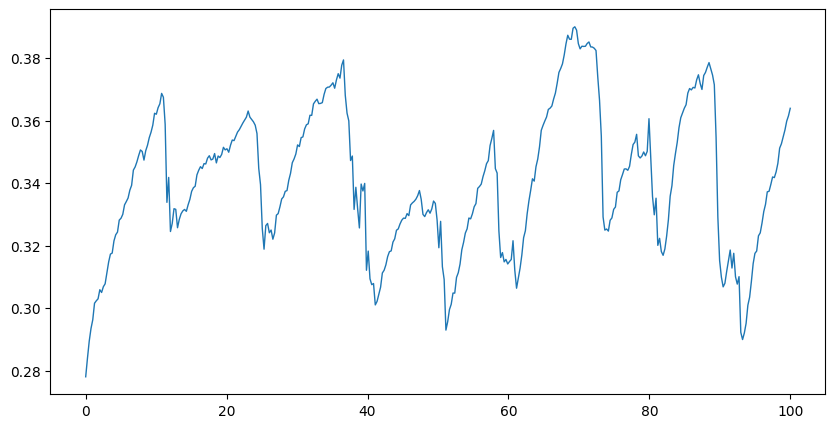

In [49]:
# capital utilisation
capital_utilisation = (params['cfirm']['acceleration']*macro['consumption'])/macro['capital']
plt.figure(figsize=(10,5))
plt.plot(years, capital_utilisation[start:], linewidth=1)
plt.show()

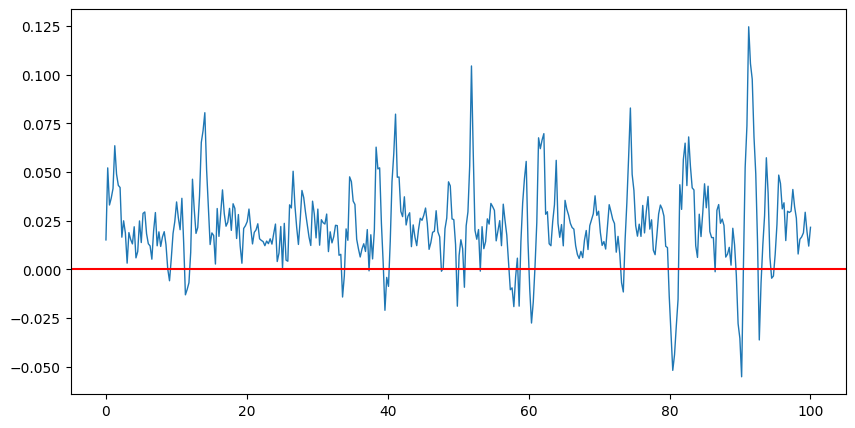

In [50]:
# real gdp growth rate (log difference)
real_gdp_growth = np.log(macro['real_gdp']) - np.log(macro['real_gdp'].shift(steps))
plt.figure(figsize=(10,5))
plt.plot(years, real_gdp_growth[start:], linewidth=1)
plt.axhline(0, color='r')
plt.show()

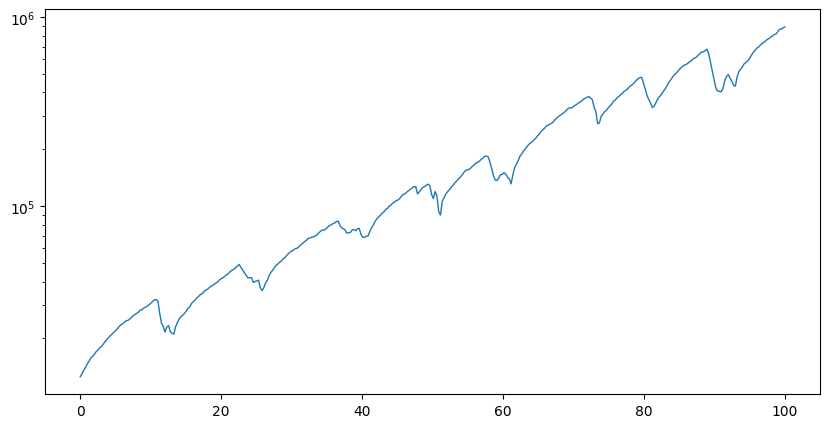

In [51]:
# total debt
plt.figure(figsize=(10,5))
plt.plot(years, macro['debt'][start:], linewidth=1)
plt.yscale('log')
plt.show()

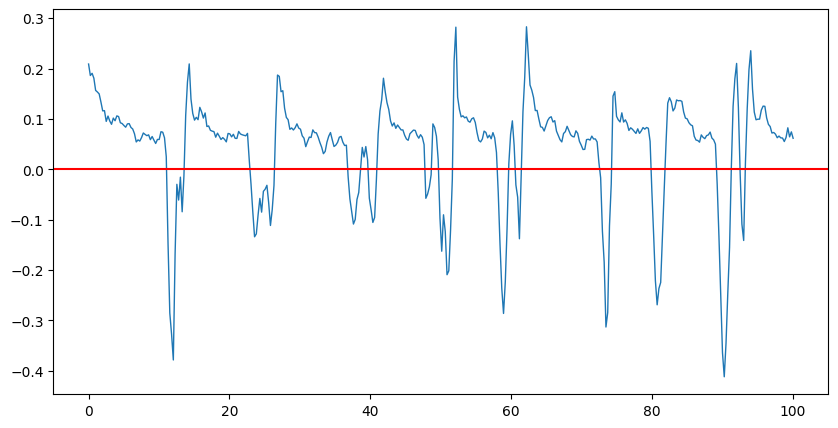

In [52]:
# credit (debt log difference)
credit = np.log(macro['debt']) - np.log(macro['debt'].shift(steps))
plt.figure(figsize=(10,5))
plt.plot(years, credit[start:], linewidth=1)
plt.axhline(0, color='r')
plt.show()

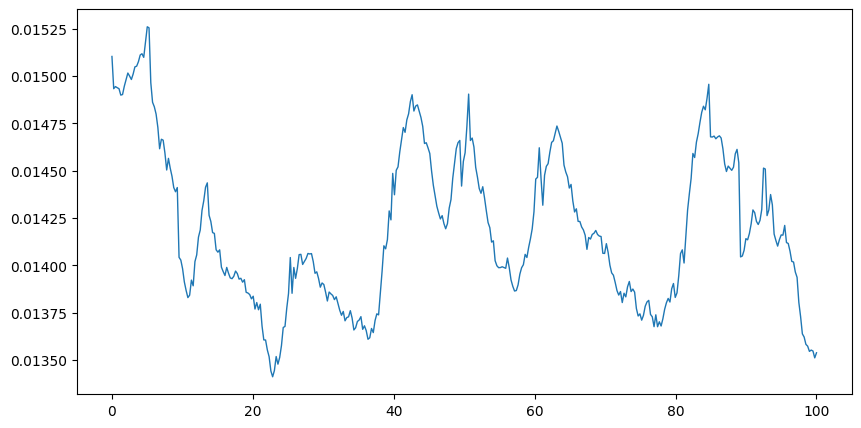

In [53]:
# loan interest 
plt.figure(figsize=(10,5))
plt.plot(years, macro['avg_loan_interest'][start:], linewidth=1)
plt.show()

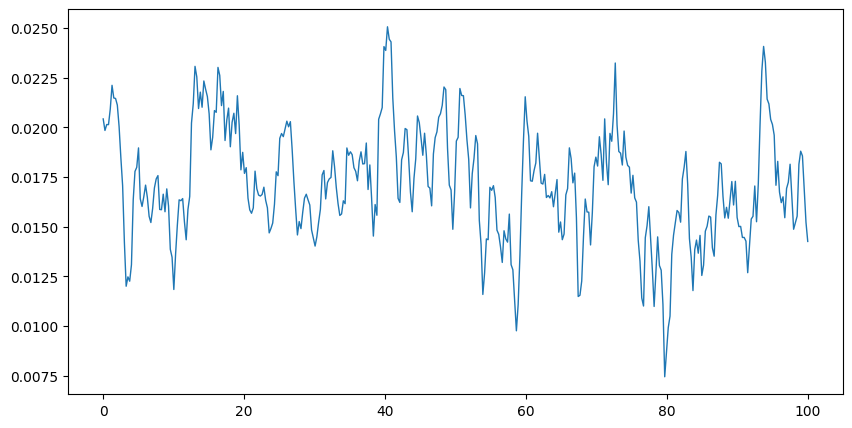

In [54]:
# inflation
inflation = np.log(macro['cfirm_price_index']) - np.log(macro['cfirm_price_index'].shift(steps))
plt.figure(figsize=(10,5))
plt.plot(years, inflation[start:], linewidth=1)
plt.show()

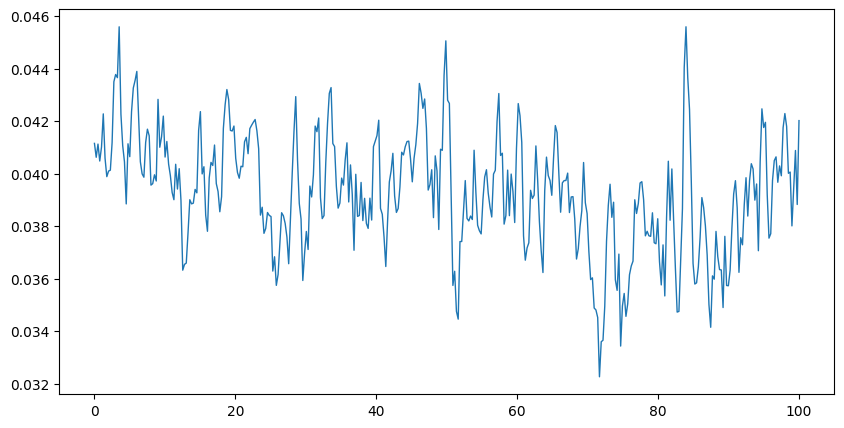

In [55]:
# wage inflation
wage_inflation = np.log(macro['avg_wage']) - np.log(macro['avg_wage'].shift(steps))
plt.figure(figsize=(10,5))
plt.plot(years, wage_inflation[start:], linewidth=1)
plt.show()

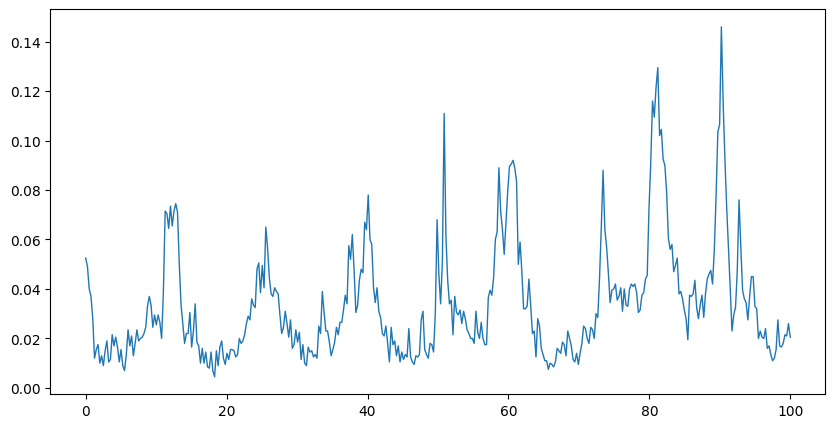

In [56]:
# unemployment rate
plt.figure(figsize=(10,5))
plt.plot(years, macro['unemployment_rate'][start:], linewidth=1)
plt.show()

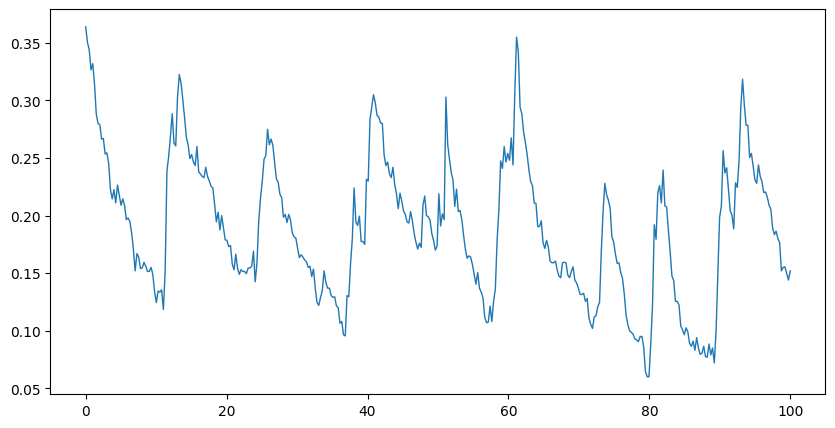

In [57]:
# vacancy rate
plt.figure(figsize=(10,5))
plt.plot(years, macro['vacancy_ratio'][start:], linewidth=1)
plt.show()

### Market Stability

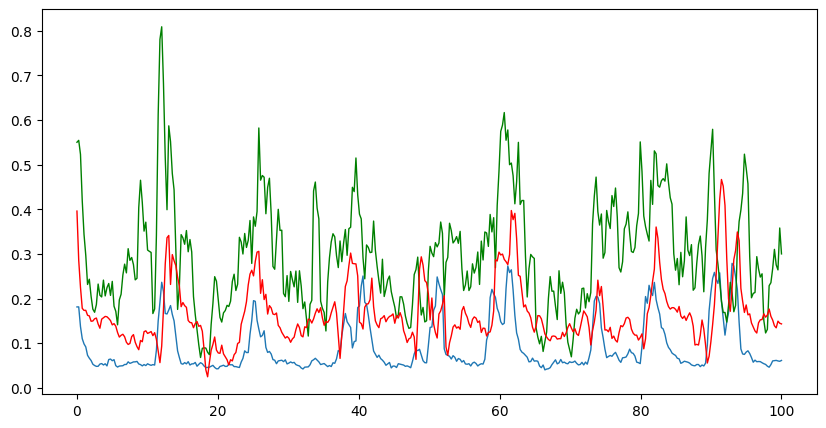

In [58]:
# hpi
plt.figure(figsize=(10,5))
plt.plot(years, macro['cfirm_hpi'][start:], linewidth=1)
plt.plot(years, macro['kfirm_hpi'][start:], color='g', linewidth=1)
plt.plot(years, macro['bank_hpi'][start:], color='r', linewidth=1)
plt.show()

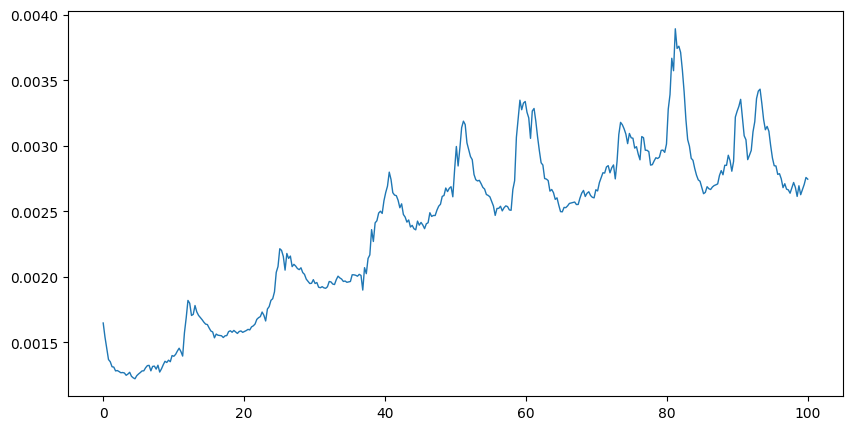

In [59]:
# cfirm nhhi
plt.figure(figsize=(10,5))
plt.plot(years, macro['cfirm_nhhi'][start:], linewidth=1)
plt.show()

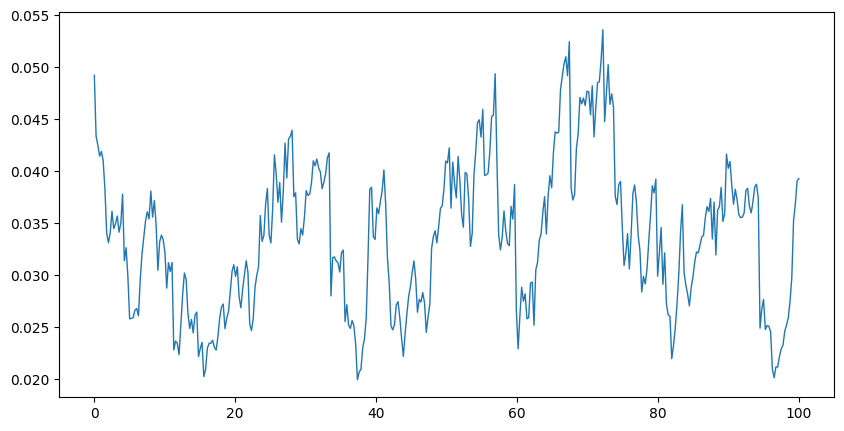

In [60]:
# kfirm nhhi
plt.figure(figsize=(10,5))
plt.plot(years, macro['kfirm_nhhi'][start:], linewidth=1)
plt.show()

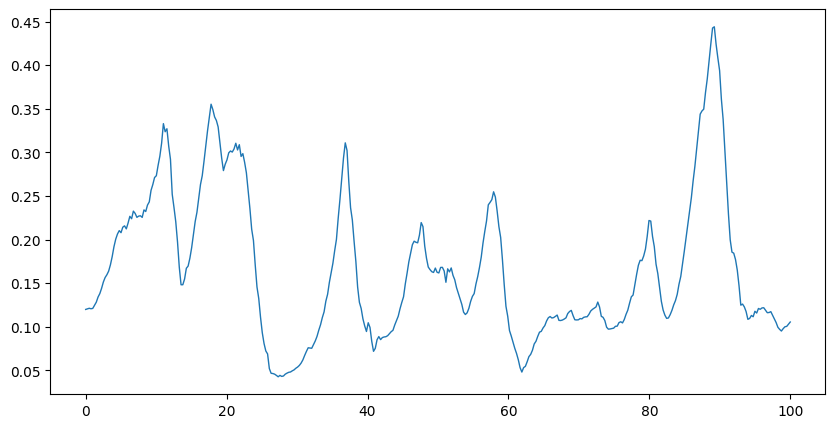

In [61]:
# bank nhhi
plt.figure(figsize=(10,5))
plt.plot(years, macro['bank_nhhi'][start:], linewidth=1)
plt.show()

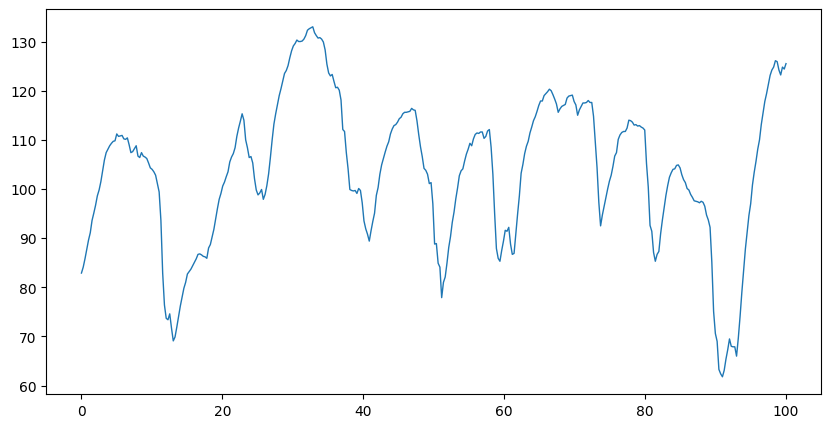

In [62]:
# bank mean firm degree
plt.figure(figsize=(10,5))
plt.plot(years, macro['bank_mean_degree'][start:], linewidth=1)
plt.show()

### Inequality

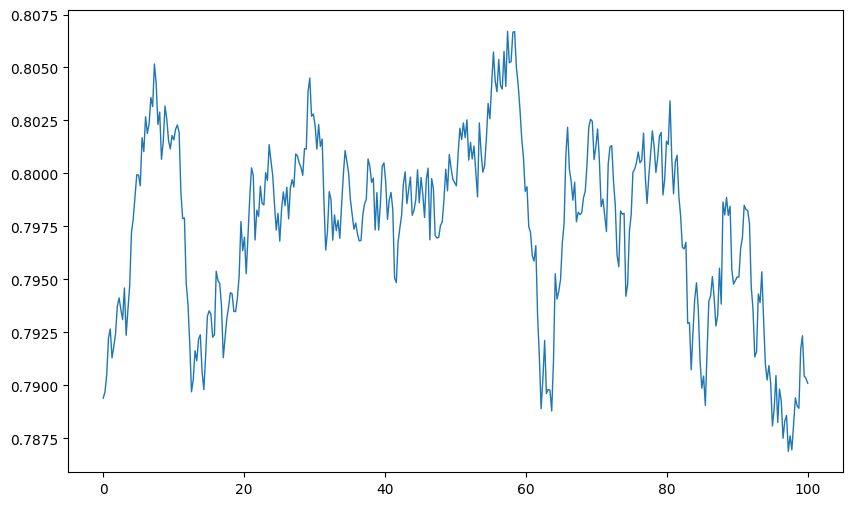

In [63]:
plt.figure(figsize=(10,6))
plt.plot(years, macro['gini'][start:], linewidth=1)
plt.show()

### Stylised Facts

                            OLS Regression Results                            
Dep. Variable:      cfirm_price_index   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     3.111
Date:                Thu, 04 Apr 2024   Prob (F-statistic):             0.0785
Time:                        16:50:11   Log-Likelihood:                 1778.2
No. Observations:                 400   AIC:                            -3552.
Df Residuals:                     398   BIC:                            -3544.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0175      0.00

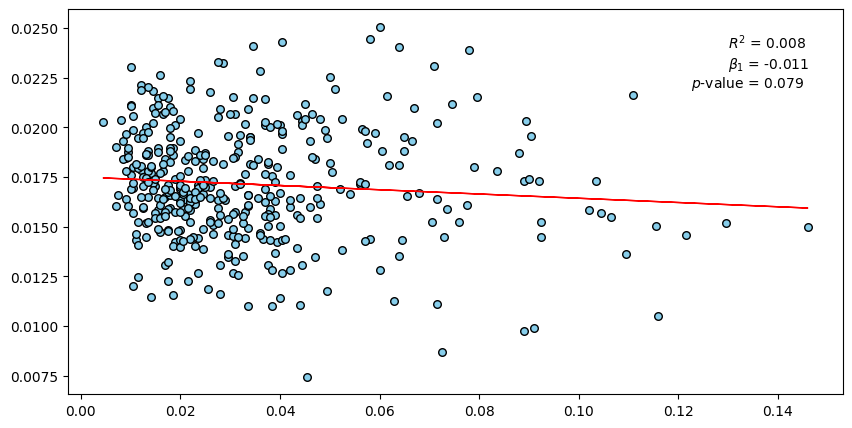

In [64]:
# Phillips Curve: relationship between inflation and unemployment rate
pc_model = sm.OLS(inflation[start:], sm.add_constant(macro['unemployment_rate'][start:]))
pc_results = pc_model.fit()
print(pc_results.summary())
# plot results
plt.figure(figsize=(10,5))
plt.scatter(x=macro['unemployment_rate'][start:], y=inflation[start:], color='skyblue', s=30, edgecolors='k')
plt.plot(macro['unemployment_rate'][start:], pc_results.params['const'] + pc_results.params['unemployment_rate']*macro['unemployment_rate'][start:], color='r', linewidth=1)
plt.text(0.13, 0.024, r'$R^2$ = ' + str(round(pc_results.rsquared, 3)))
plt.text(0.13, 0.023, r'$\beta_1$ = ' + str(round(pc_results.params['unemployment_rate'], 3)))
plt.text(0.1225, 0.022, r'$p$-value = ' + str(round(pc_results.pvalues['unemployment_rate'], 3)))
plt.show()

                            OLS Regression Results                            
Dep. Variable:               avg_wage   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     33.45
Date:                Thu, 04 Apr 2024   Prob (F-statistic):           1.48e-08
Time:                        16:50:13   Log-Likelihood:                 1893.4
No. Observations:                 400   AIC:                            -3783.
Df Residuals:                     398   BIC:                            -3775.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0402      0.00

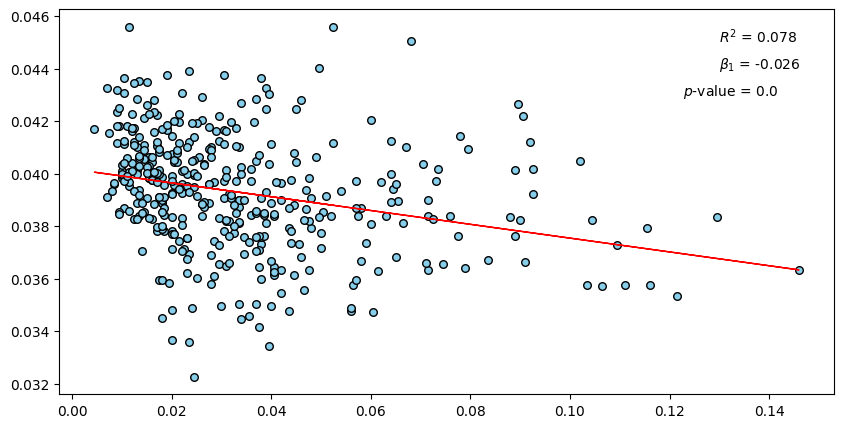

In [65]:
# Wage Phillips Curve: relationship between inflation and unemployment rate
wpc_model = sm.OLS(wage_inflation[start:], sm.add_constant(macro['unemployment_rate'][start:]))
wpc_results = wpc_model.fit()
print(wpc_results.summary())
# plot results
plt.figure(figsize=(10,5))
plt.scatter(x=macro['unemployment_rate'][start:], y=wage_inflation[start:], color='skyblue', s=30, edgecolors='k')
plt.plot(macro['unemployment_rate'][start:], wpc_results.params['const'] + wpc_results.params['unemployment_rate']*macro['unemployment_rate'][start:], color='r', linewidth=1)
plt.text(0.13, 0.045, r'$R^2$ = ' + str(round(wpc_results.rsquared, 3)))
plt.text(0.13, 0.044, r'$\beta_1$ = ' + str(round(wpc_results.params['unemployment_rate'], 3)))
plt.text(0.1227, 0.043, r'$p$-value = ' + str(round(wpc_results.pvalues['unemployment_rate'], 3)))
plt.show()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.228
Model:                            OLS   Adj. R-squared:                  0.226
Method:                 Least Squares   F-statistic:                     117.3
Date:                Thu, 04 Apr 2024   Prob (F-statistic):           3.98e-24
Time:                        16:50:13   Log-Likelihood:                 1142.1
No. Observations:                 400   AIC:                            -2280.
Df Residuals:                     398   BIC:                            -2272.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.8912      0.00

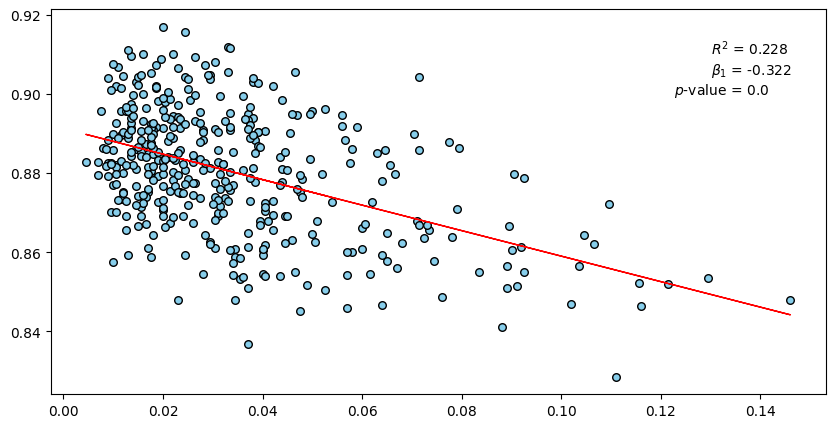

In [66]:
# Profit Share Phillips Curve: relationship between inflation and unemployment rate
pps_model = sm.OLS(1 - profit_share[start:], sm.add_constant(macro['unemployment_rate'][start:]))
pps_results = pps_model.fit()
print(pps_results.summary())
# plot results
plt.figure(figsize=(10,5))
plt.scatter(x=macro['unemployment_rate'][start:], y=1 - profit_share[start:], color='skyblue', s=30, edgecolors='k')
plt.plot(macro['unemployment_rate'][start:], pps_results.params['const'] + pps_results.params['unemployment_rate']*macro['unemployment_rate'][start:], color='r', linewidth=1)
plt.text(0.13, 0.91, r'$R^2$ = ' + str(round(pps_results.rsquared, 3)))
plt.text(0.13, 0.905, r'$\beta_1$ = ' + str(round(pps_results.params['unemployment_rate'], 3)))
plt.text(0.1227, 0.90, r'$p$-value = ' + str(round(pps_results.pvalues['unemployment_rate'], 3)))
plt.show()

                            OLS Regression Results                            
Dep. Variable:          vacancy_ratio   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     9.216
Date:                Thu, 04 Apr 2024   Prob (F-statistic):            0.00256
Time:                        16:50:14   Log-Likelihood:                 558.33
No. Observations:                 400   AIC:                            -1113.
Df Residuals:                     398   BIC:                            -1105.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.1750      0.00

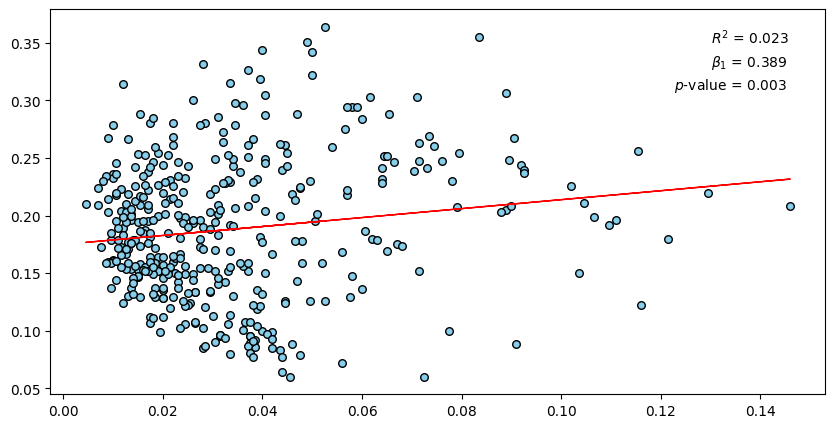

In [67]:
# Belverage Curve: relationship between vacancy ratio and unemployment rate
bc_model = sm.OLS(macro['vacancy_ratio'][start:], sm.add_constant(macro['unemployment_rate'][start:]))
bc_results = bc_model.fit()
print(bc_results.summary())
# plot results
plt.figure(figsize=(10,5))
plt.scatter(x=macro['unemployment_rate'][start:], y=macro['vacancy_ratio'][start:], color='skyblue', s=30, edgecolors='k')
plt.plot(macro['unemployment_rate'][start:], bc_results.params['const'] + bc_results.params['unemployment_rate']*macro['unemployment_rate'][start:], color='r', linewidth=1)
plt.text(0.13, 0.35, r'$R^2$ = ' + str(round(bc_results.rsquared, 3)))
plt.text(0.13, 0.33, r'$\beta_1$ = ' + str(round(bc_results.params['unemployment_rate'], 3)))
plt.text(0.1227, 0.31, r'$p$-value = ' + str(round(bc_results.pvalues['unemployment_rate'], 3)))
plt.show()

                            OLS Regression Results                            
Dep. Variable:               real_gdp   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     3071.
Date:                Thu, 04 Apr 2024   Prob (F-statistic):          3.26e-189
Time:                        16:50:14   Log-Likelihood:                 1402.6
No. Observations:                 400   AIC:                            -2801.
Df Residuals:                     398   BIC:                            -2793.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0217      0.00

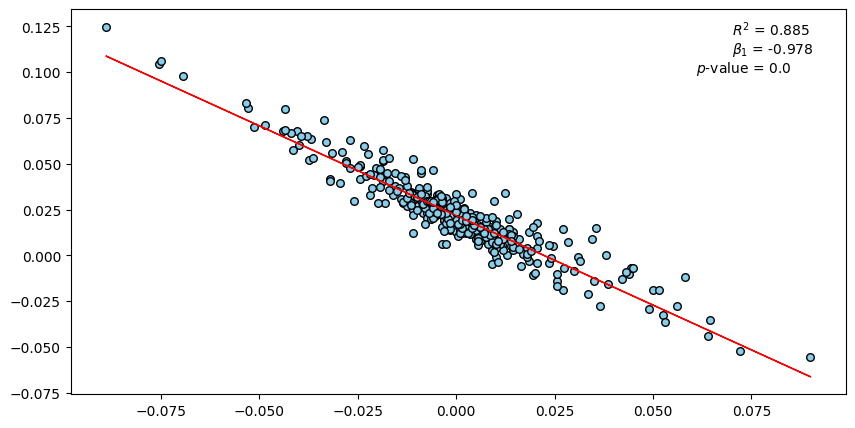

In [68]:
# Oken Curve: relationship between the in unemployment rate and real GDP growth rate
change_unemployment = macro['unemployment_rate'] - macro['unemployment_rate'].shift(steps)
oc_model = sm.OLS(real_gdp_growth[start:], sm.add_constant(change_unemployment[start:]))
oc_results = oc_model.fit()
print(oc_results.summary())
# plot results
plt.figure(figsize=(10,5))
plt.scatter(x=change_unemployment[start:], y=real_gdp_growth[start:], color='skyblue', s=30, edgecolors='k')
plt.plot(change_unemployment[start:], oc_results.params['const'] + oc_results.params['unemployment_rate']*change_unemployment[start:], color='r', linewidth=1)
plt.text(0.07, 0.12, r'$R^2$ = ' + str(round(oc_results.rsquared, 3)))
plt.text(0.07, 0.11, r'$\beta_1$ = ' + str(round(oc_results.params['unemployment_rate'], 3)))
plt.text(0.061, 0.10, r'$p$-value = ' + str(round(oc_results.pvalues['unemployment_rate'], 3)))
plt.show()

                            OLS Regression Results                            
Dep. Variable:                   debt   R-squared:                       0.423
Model:                            OLS   Adj. R-squared:                  0.421
Method:                 Least Squares   F-statistic:                     291.2
Date:                Thu, 04 Apr 2024   Prob (F-statistic):           2.14e-49
Time:                        16:50:15   Log-Likelihood:                 447.49
No. Observations:                 400   AIC:                            -891.0
Df Residuals:                     398   BIC:                            -883.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.1416      0.00

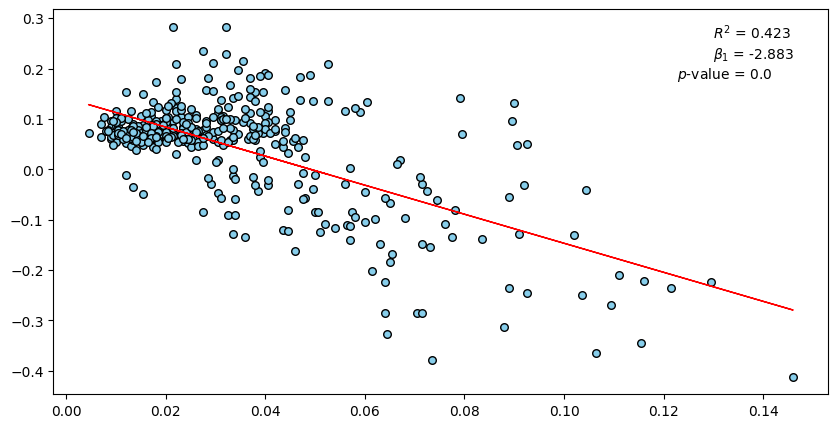

In [69]:
# Keen Curve: relationship between credit and unemployment rate
bc_model = sm.OLS(credit[start:], sm.add_constant(macro['unemployment_rate'][start:]))
bc_results = bc_model.fit()
print(bc_results.summary())
# plot results
plt.figure(figsize=(10,5))
plt.scatter(x=macro['unemployment_rate'][start:], y=credit[start:], color='skyblue', s=30, edgecolors='k')
plt.plot(macro['unemployment_rate'][start:], bc_results.params['const'] + bc_results.params['unemployment_rate']*macro['unemployment_rate'][start:], color='r', linewidth=1)
plt.text(0.13, 0.26, r'$R^2$ = ' + str(round(bc_results.rsquared, 3)))
plt.text(0.13, 0.22, r'$\beta_1$ = ' + str(round(bc_results.params['unemployment_rate'], 3)))
plt.text(0.1227, 0.18, r'$p$-value = ' + str(round(bc_results.pvalues['unemployment_rate'], 3)))
plt.show()

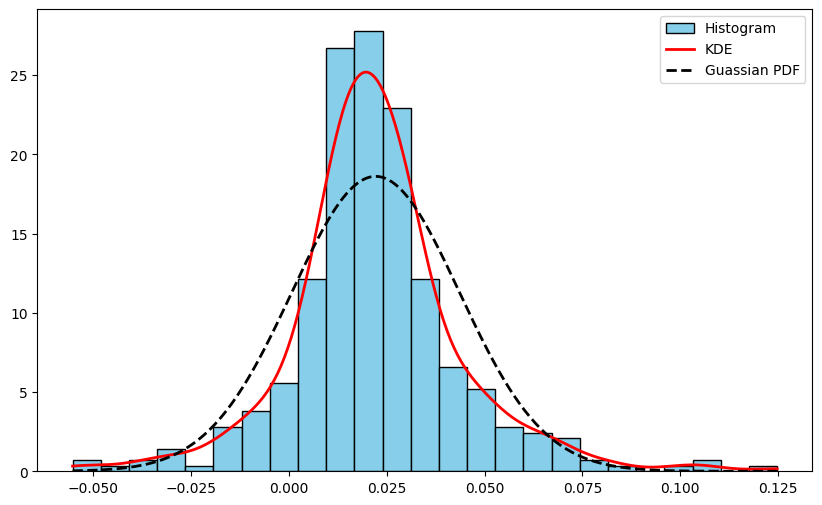

Real GDP Growth Mean =  0.022152896769418073
Real GDP Growth Standard Deviation 0.02143024862356305


In [70]:
# Real GDP growth rates distribution
plt.figure(figsize=(10,6))
plt.hist(real_gdp_growth[start:], bins=25, color='skyblue', edgecolor="black", density=True, label='Histogram')
# KDE
kernel = stats.gaussian_kde(real_gdp_growth[start:])
x = np.linspace(real_gdp_growth[start:].min(), real_gdp_growth[start:].max(), 400)
plt.plot(x, kernel.evaluate(x), color='r', linewidth=2, label='KDE')
# Gaussian fit
mu, sigma = stats.norm.fit(real_gdp_growth[start:])
pdf = stats.norm.pdf(x, mu, sigma)
plt.plot(x, pdf, color='k', linestyle='--', linewidth=2, label='Guassian PDF')
plt.legend(loc='upper right')
plt.show()
print('Real GDP Growth Mean = ', mu)
print('Real GDP Growth Standard Deviation', sigma)

In [71]:
# Kolmogorov-Smirnov Test for Nomaliy
ks_result = stats.kstest(real_gdp_growth[start:], 'norm')
print(ks_result)

KstestResult(statistic=0.4780027699719676, pvalue=1.5862472068369189e-84, statistic_location=-0.03634716824784512, statistic_sign=-1)


Calculating best minimal value for power law fit


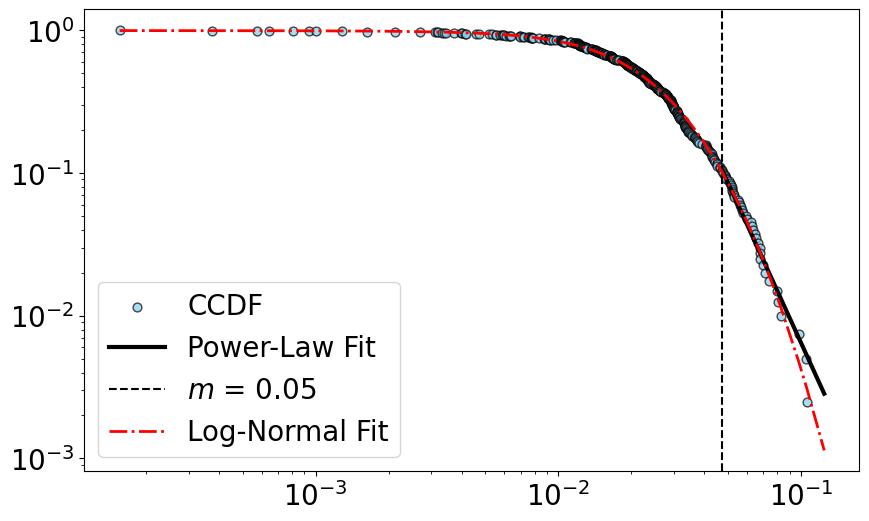

Power law exponent = 4.7256990142486375
Power law minimum = 0.047347117788625326
Distribution compare = (-0.4675914523787844, 0.5220744955720256)


In [77]:
# data 
data = np.abs(real_gdp_growth[start:])
# power law fit results 
results = pl.Fit(data)
a, m = results.alpha, results.xmin
# complementary cdf 
plt.figure(figsize=(10,6))
# x values 
x = np.sort(data)
# complementary cdf (ccdf)
cdf = np.arange(1,len(data)+1)/(len(data))
ccdf = 1 - cdf
plt.scatter(x, ccdf, color='skyblue', edgecolors='k', s=40, alpha=0.7, label='CCDF')
# power law fit
# => rescale to start fit from cut off
index = np.where(x == m)[0][0]
rescale = ccdf[index]
power_law_fit = np.where(x >= m, np.power((m)/x,a-1)*rescale, np.nan)
plt.plot(x, power_law_fit, color='k', linewidth=3, label='Power-Law Fit')
# power law cut off (mF)
plt.axvline(m, color='k', linestyle='--', label=r'$m$'f' = {round(m, 2)}') # type: ignore
# lognormal distribution fit
params = stats.lognorm.fit(data)
cdf = stats.lognorm.cdf(x, params[0], params[1], params[2])
plt.plot(x, 1 - cdf, color='r', linestyle='-.', linewidth=2, label='Log-Normal Fit')
# log-log axis
plt.loglog()
# legend
plt.legend(fontsize=20, loc='lower left')
# tick size
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.show()
print(f'Power law exponent = {a}')
print(f'Power law minimum = {m}')
print(f"Distribution compare = {results.distribution_compare('power_law', 'lognormal')}")

In [78]:
# number of crises 
num_crises = 0
count = 0
down = False
in_crisis = np.where(real_gdp_growth[start:] < 0, 1, 0)
num_crises = np.where((in_crisis[2:] == 0) & (in_crisis[1:-1] == 1) & (in_crisis[:-2] == 1) , 1, 0).sum()
print(f'Number of Economic Recessions (two quarters of negative real GDP growth) = {num_crises}')

Number of Economic Recessions (two quarters of negative real GDP growth) = 10


## Micro Analysis

### Stylised Facts

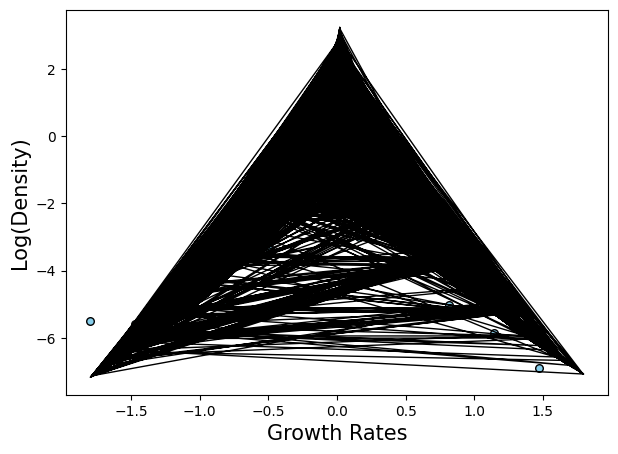

In [79]:
# cfirm growth rates distribution
growth_rates = pd.read_sql_query(
    f"""
        SELECT output_growth
        FROM 
            firm_data
        WHERE 
            firm_type = 'ConsumptionFirm' and abs(output_growth) < 1.8 and time > {start}
    ;
    """,
    con
)
# probability model
model = stats.gennorm
# estimated parameters
estimates = model.fit(growth_rates)
# fit model
rv = model(estimates[0], estimates[1], estimates[2])
# probability density function of data
pdf = rv.pdf(np.sort(growth_rates))
# histogram of data
hist = np.histogram(growth_rates, bins=11)
# figure size
plt.figure(figsize=(7,5))
# historgram scatter plot raw data
plt.scatter(hist[1][:-1], np.log(hist[0]/hist[0].sum()), color='skyblue', s=30, edgecolors='k')
# histogram scatter plot pdf
plt.plot(np.sort(growth_rates), np.log(pdf), color='k', linewidth=1)
# labels 
plt.ylabel('Log(Density)', fontsize=15)
plt.xlabel('Growth Rates', fontsize=15)
plt.show()

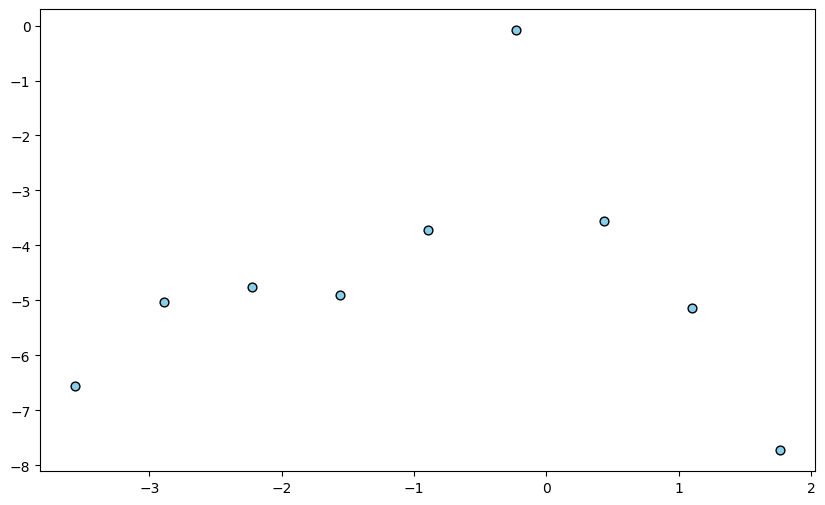

In [81]:
growth_rates = pd.read_sql_query(
    f"""
        SELECT output_growth
        FROM 
            firm_data
        WHERE 
            firm_type = 'ConsumptionFirm' and time > {start}
    ;
    """,
    con
)
hist_data = np.histogram(growth_rates, bins=9)
plt.figure(figsize=(10,6))
plt.scatter(hist_data[1][:-1], np.log(hist_data[0]/hist_data[0].sum()), color='skyblue', edgecolors='k', s=40)
# generalised normal fit
# params = stats.gennorm.fit(growth_rates)
# pdf = stats.gennorm.pdf(growth_rates, params[0], params[1], params[2]).reshape(1, -1)[0]
# plt.plot(growth_rates, np.log(pdf), color='r', linestyle='-.', linewidth=2, label='Log-Normal Fit')
plt.show()

Calculating best minimal value for power law fit


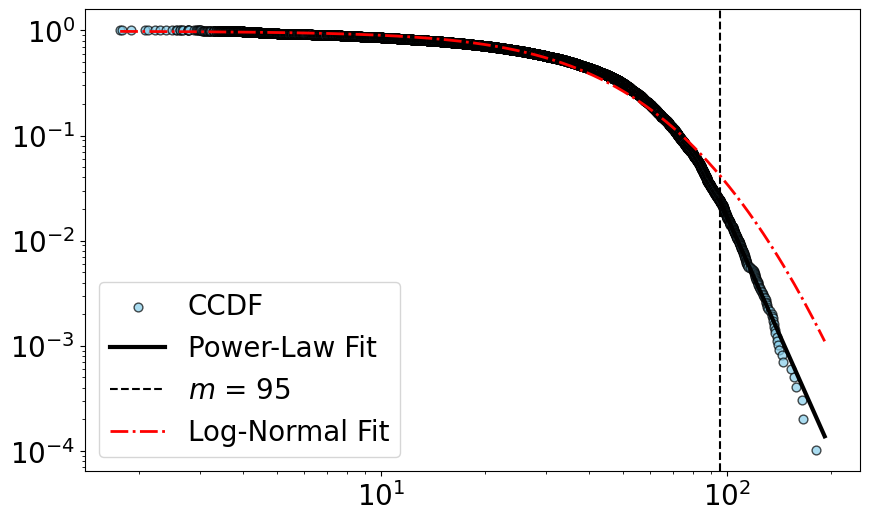

Power law exponent = 8.398596765145292
Power law minimum = 95.34963467584507
Distribution compare = (-0.453561896679775, 0.5599979991468682)


In [72]:
size = pd.read_sql_query(
    f"""
        SELECT output
        FROM 
            firm_data
        WHERE 
            firm_type = 'ConsumptionFirm' and time = {middle}
    ;
    """,
    con
)
# data 
data = size.to_numpy().reshape(1, -1)[0]
# power law fit results 
results = pl.Fit(data)
a, m = results.alpha, results.xmin
# complementary cdf 
plt.figure(figsize=(10,6))
# x values 
x = np.sort(data)
# complementary cdf (ccdf)
cdf = np.arange(1,len(data)+1)/(len(data))
ccdf = 1 - cdf
plt.scatter(x, ccdf, color='skyblue', edgecolors='k', alpha=0.7, s=40, label='CCDF')
# power law fit
# => rescale to start fit from cut off
index = np.where(x == m)[0][0]
rescale = ccdf[index]
power_law_fit = np.where(x >= m, np.power((m)/x,a-1)*rescale, np.nan)
plt.plot(x, power_law_fit, color='k', linewidth=3, label='Power-Law Fit')
# power law cut off (mF)
plt.axvline(m, color='k', linestyle='--', label=r'$m$'f' = {round(m)}') # type: ignore
# lognormal distribution
params = stats.lognorm.fit(data)
cdf = stats.lognorm.cdf(x, params[0], params[1], params[2])
plt.plot(x, 1 - cdf, color='r', linestyle='-.', linewidth=2, label='Log-Normal Fit')
# log-log axis
plt.loglog()
# legend
plt.legend(fontsize=20, loc='lower left')
# tick size
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.show()
print(f'Power law exponent = {a}')
print(f'Power law minimum = {m}')
print(f"Distribution compare = {results.distribution_compare('power_law', 'lognormal')}")

Calculating best minimal value for power law fit


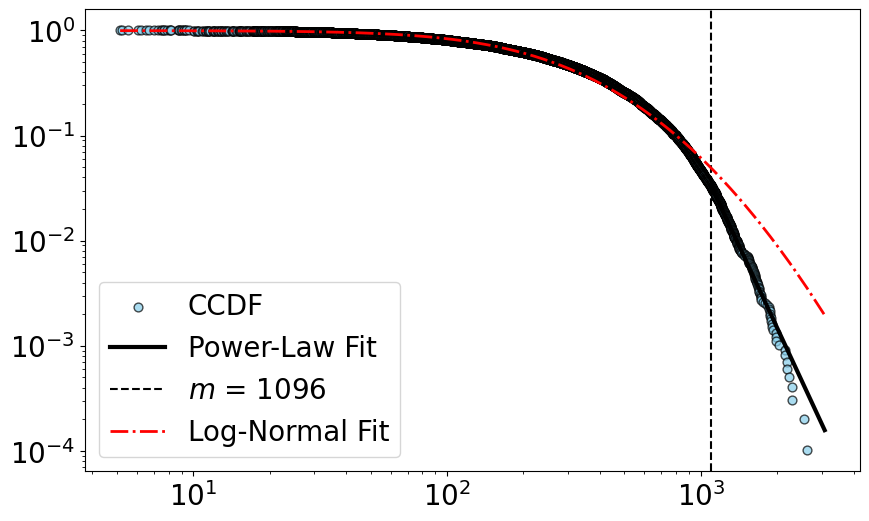

Power law exponent = 6.195669338832515
Power law minimum = 1096.229673118111
Distribution compare = (-1.0104963459728884, 0.3834295918954226)


In [73]:
size = pd.read_sql_query(
    f"""
        SELECT capital
        FROM 
            firm_data
        WHERE 
            firm_type = 'ConsumptionFirm' and time = {middle}
    ;
    """,
    con
)
# data 
data = size.to_numpy().reshape(1, -1)[0]
# power law fit results 
results = pl.Fit(data)
a, m = results.alpha, results.xmin
# complementary cdf 
plt.figure(figsize=(10,6))
# x values 
x = np.sort(data)
# complementary cdf (ccdf)
cdf = np.arange(1,len(data)+1)/(len(data))
ccdf = 1 - cdf
plt.scatter(x, ccdf, color='skyblue', edgecolors='k', alpha=0.7, s=40, label='CCDF')
# power law fit
# => rescale to start fit from cut off
index = np.where(x == m)[0][0]
rescale = ccdf[index]
power_law_fit = np.where(x >= m, np.power((m)/x,a-1)*rescale, np.nan)
plt.plot(x, power_law_fit, color='k', linewidth=3, label='Power-Law Fit')
# power law cut off (mF)
plt.axvline(m, color='k', linestyle='--', label=r'$m$'f' = {round(m)}') # type: ignore
# lognormal distribution
params = stats.lognorm.fit(data)
cdf = stats.lognorm.cdf(x, params[0], params[1], params[2])
plt.plot(x, 1 - cdf, color='r', linestyle='-.', linewidth=2, label='Log-Normal Fit')
# log-log axis
plt.loglog()
# legend
plt.legend(fontsize=20, loc='lower left')
# tick size
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.show()
print(f'Power law exponent = {a}')
print(f'Power law minimum = {m}')
print(f"Distribution compare = {results.distribution_compare('power_law', 'lognormal')}")

Calculating best minimal value for power law fit


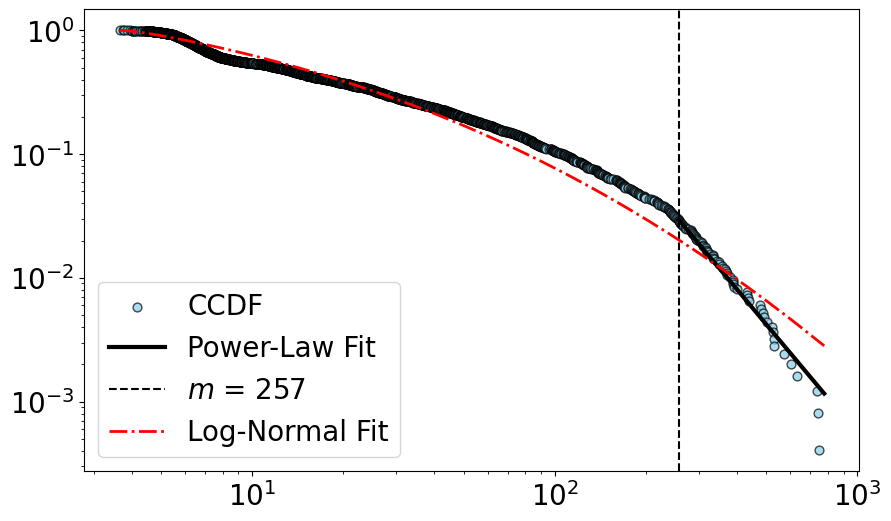

Power law exponent = 3.921384037504866
Power law minimum = 256.9507676442831
Distribution compare = (-1.1757968066123823, 0.305098271316143)


In [74]:
size = pd.read_sql_query(
    f"""
        SELECT output
        FROM 
            firm_data
        WHERE 
            firm_type = 'CapitalFirm' and time = {middle}
    ;
    """,
    con
)
# data 
data = size.to_numpy().reshape(1, -1)[0]
# power law fit results 
results = pl.Fit(data)
a, m = results.alpha, results.xmin
# complementary cdf 
plt.figure(figsize=(10,6))
# x values 
x = np.sort(data)
# complementary cdf (ccdf)
cdf = np.arange(1,len(data)+1)/(len(data))
ccdf = 1 - cdf
plt.scatter(x, ccdf, color='skyblue', edgecolors='k', alpha=0.7, s=40, label='CCDF')
# power law fit
# => rescale to start fit from cut off
index = np.where(x == m)[0][0]
rescale = ccdf[index]
power_law_fit = np.where(x >= m, np.power((m)/x,a-1)*rescale, np.nan)
plt.plot(x, power_law_fit, color='k', linewidth=3, label='Power-Law Fit')
# power law cut off (mF)
plt.axvline(m, color='k', linestyle='--', label=r'$m$'f' = {round(m)}') # type: ignore
# lognormal distribution
params = stats.lognorm.fit(data)
cdf = stats.lognorm.cdf(x, params[0], params[1], params[2])
plt.plot(x, 1 - cdf, color='r', linestyle='-.', linewidth=2, label='Log-Normal Fit')
# log-log axis
plt.loglog()
# legend
plt.legend(fontsize=20, loc='lower left')
# tick size
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.show()
print(f'Power law exponent = {a}')
print(f'Power law minimum = {m}')
print(f"Distribution compare = {results.distribution_compare('power_law', 'lognormal')}")

Calculating best minimal value for power law fit


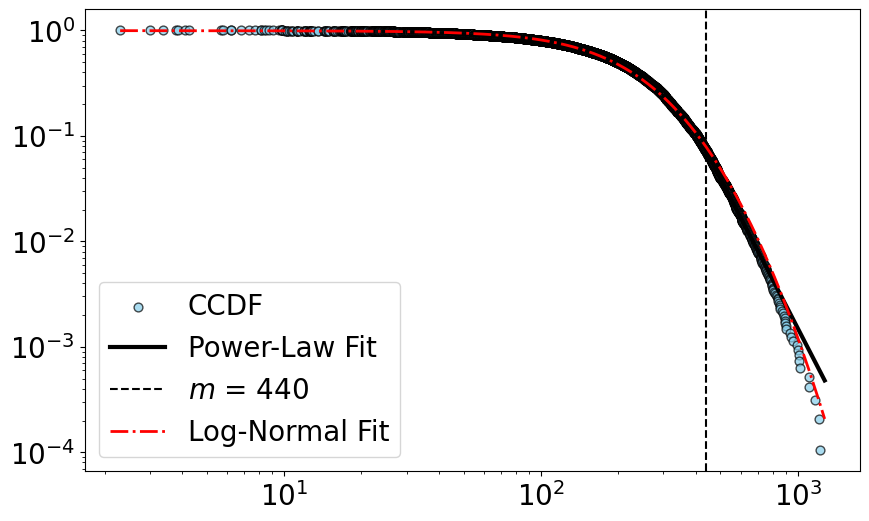

Power law exponent = 5.720610140878622
Power law minimum = 439.60132174791113
Distribution compare = (-3.60518938348134, 0.1026390189476335)


In [76]:
debt = pd.read_sql_query(
    f"""
        SELECT debt
        FROM 
            firm_data
        WHERE 
            firm_type = 'ConsumptionFirm' and time = {middle}
    ;
    """,
    con
)
# data 
data = debt.to_numpy()[debt>1].reshape(1, -1)[0]
# power law fit results 
results = pl.Fit(data)
a, m = results.alpha, results.xmin
# complementary cdf 
plt.figure(figsize=(10,6))
# x values 
x = np.sort(data)
# complementary cdf (ccdf)
cdf = np.arange(1,len(data)+1)/(len(data))
ccdf = 1 - cdf
plt.scatter(x, ccdf, color='skyblue', edgecolors='k', alpha=0.7, s=40, label='CCDF')
# power law fit
# => rescale to start fit from cut off
index = np.where(x == m)[0][0]
rescale = ccdf[index]
power_law_fit = np.where(x >= m, np.power((m)/x,a-1)*rescale, np.nan)
plt.plot(x, power_law_fit, color='k', linewidth=3, label='Power-Law Fit')
# power law cut off (mF)
plt.axvline(m, color='k', linestyle='--', label=r'$m$'f' = {round(m)}') # type: ignore
# lognormal distribution
params = stats.lognorm.fit(data)
cdf = stats.lognorm.cdf(x, params[0], params[1], params[2])
plt.plot(x, 1 - cdf, color='r', linestyle='-.', linewidth=2, label='Log-Normal Fit')
# log-log axis
plt.loglog()
# legend
plt.legend(fontsize=20, loc='lower left')
# tick size
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.show()
print(f'Power law exponent = {a}')
print(f'Power law minimum = {m}')
print(f"Distribution compare = {results.distribution_compare('power_law', 'lognormal')}")

### Consumption Firms

In [86]:
# cfirm data
cfirms = pd.read_sql_query(
    f"""
        SELECT * 
        FROM 
            firm_data
        WHERE 
            firm_type = 'ConsumptionFirm'
    ;
    """,
    con
)
cfirms.describe()

,simulation,time,productivity,productivity_growth,expected_productivity,output,output_growth,desired_output,demand,expected_demand,...,age,market_share,capital,desired_utilisation,investment,investment_cost,desired_investment_cost,desired_investment_loan,desired_debt_ratio,desired_debt
count,118941.0,118941.000000,118941.000000,118941.000000,118941.000000,118941.000000,118941.000000,118941.000000,1.189410e+05,118941.000000,...,118941.000000,118941.000000,118941.000000,118941.000000,118941.000000,118941.000000,1.189410e+05,118941.000000,118941.000000,118941.000000
mean,0.0,300.117890,7.425939,0.019592,7.463162,58.906941,-0.005480,71.878298,7.940307e+01,71.878298,...,32.776297,0.005045,517.663904,0.579551,14.061418,73.654861,2.288368e+01,25.220292,0.772716,390.546363
std,0.0,173.208483,6.803203,0.030003,6.837305,78.972065,0.330285,87.002743,1.166129e+02,87.002743,...,31.934281,0.002983,843.266217,0.282316,34.034767,243.887007,1.673905e+02,128.620875,0.533107,909.968381
min,0.0,1.000000,0.888939,-0.129920,0.893395,0.789972,-3.557586,3.593929,-8.565502e-16,3.593929,...,0.250000,0.000135,2.310668,0.125504,0.000000,0.000000,-4.547474e-13,0.000000,-4.611469,-4207.086088
25%,0.0,150.000000,2.155550,-0.000518,2.166355,11.140925,-0.014221,16.479990,1.421035e+01,16.479990,...,8.750000,0.003103,77.251770,0.327013,0.000000,0.000000,0.000000e+00,0.000000,0.578292,10.481673
50%,0.0,300.000000,4.740225,0.019530,4.763986,29.589508,0.018818,39.785683,3.737903e+01,39.785683,...,21.250000,0.004883,236.130575,0.518204,1.659638,1.805579,0.000000e+00,0.000000,0.890351,68.236647
75%,0.0,450.000000,10.748065,0.039790,10.801940,72.487041,0.051106,93.729722,9.395454e+01,93.729722,...,47.000000,0.006358,583.235059,0.864765,12.579908,30.082859,0.000000e+00,0.763891,1.121136,349.547274
max,0.0,600.000000,38.030754,0.170325,38.221384,958.453331,2.429706,999.647529,2.181195e+03,999.647529,...,150.000000,0.024637,14999.371248,1.000000,983.194480,9108.270979,7.669633e+03,5560.589653,2.014722,18238.401237


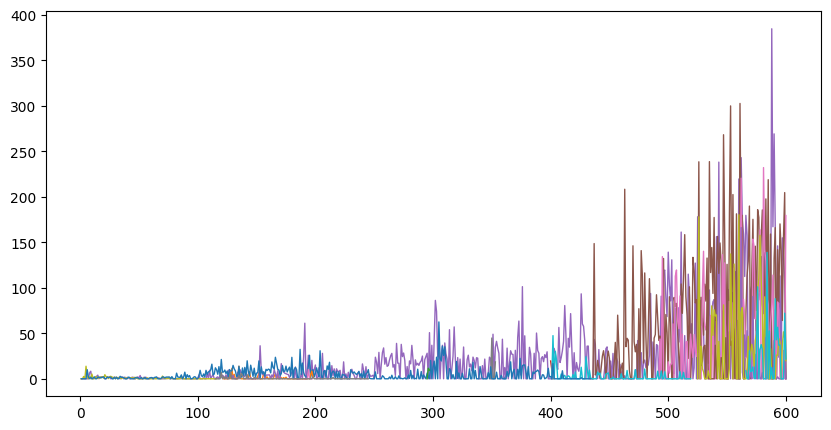

In [87]:
# lumpy investment
plt.figure(figsize=(10,5))
cfirm_output = pd.pivot_table(cfirms, values=['investment'], index=['time'], columns=['id'])
# random

for col in np.random.choice(cfirm_output.columns, size=20, replace=False):
    plt.plot(cfirm_output[col], linewidth=1)
    
plt.show()

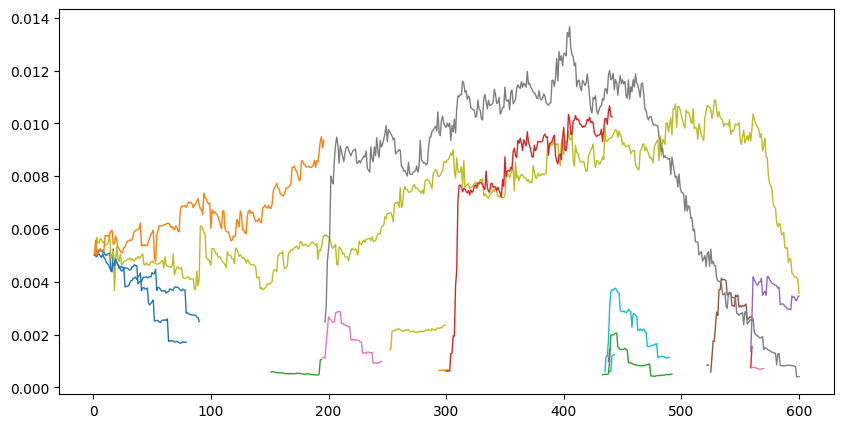

In [88]:
# persistant market shares
plt.figure(figsize=(10,5))
cfirm_output = pd.pivot_table(cfirms, values=['market_share'], index=['time'], columns=['id'])
# random

for col in np.random.choice(cfirm_output.columns, size=20, replace=False):
    plt.plot(cfirm_output[col], linewidth=1)
    
plt.show()

### Capital Firms

In [89]:
# cfirm data
kfirms = pd.read_sql_query(
    f"""
        SELECT * 
        FROM 
            firm_data
        WHERE 
            firm_type = 'CapitalFirm'
    ;
    """,
    con
)
kfirms.describe()

,simulation,time,productivity,productivity_growth,expected_productivity,output,output_growth,desired_output,demand,expected_demand,...,age,market_share,capital,desired_utilisation,investment,investment_cost,desired_investment_cost,desired_investment_loan,desired_debt_ratio,desired_debt
count,29810.0,29810.000000,29810.000000,29810.000000,29810.000000,29810.000000,29810.000000,29810.000000,29810.000000,29810.000000,...,29810.000000,29810.000000,29810.0,29810.0,29810.0,29810.0,29810.0,29810.0,29810.0,29810.0
mean,0.0,300.603422,9.662534,0.019119,9.710968,57.171023,0.005815,93.060399,115.440803,99.801640,...,27.222895,0.020127,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,173.361107,9.155856,0.030011,9.201750,109.503677,0.656128,135.702114,224.720348,132.650630,...,25.518108,0.023629,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,1.000000,0.930936,-0.100186,0.935603,0.930936,-3.726712,0.935603,0.000000,4.163196,...,0.250000,0.001460,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,151.000000,2.487920,-0.001488,2.500391,7.228175,-0.012000,15.467289,3.080055,20.741657,...,8.500000,0.003873,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,301.000000,6.324885,0.019024,6.356589,18.265243,0.033468,46.456655,33.176350,57.492983,...,19.250000,0.009755,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,451.000000,14.215268,0.039387,14.286522,54.512682,0.218315,110.264837,123.195000,116.438957,...,37.750000,0.027883,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,0.0,600.000000,49.748245,0.136619,49.997609,1472.734745,2.741961,1527.944320,3612.464178,1389.040291,...,150.000000,0.196937,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


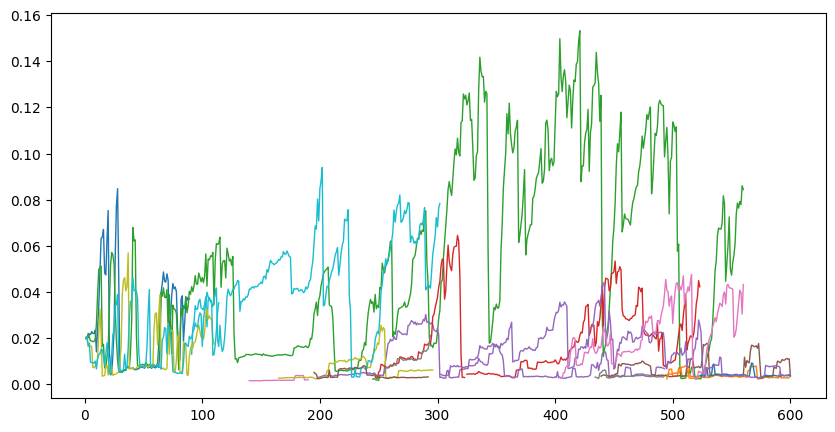

In [90]:
# persistant market shares
plt.figure(figsize=(10,5))
cfirm_output = pd.pivot_table(kfirms, values=['market_share'], index=['time'], columns=['id'])
# random

for col in np.random.choice(cfirm_output.columns, size=20, replace=False):
    plt.plot(cfirm_output[col], linewidth=1)
    
plt.show()

### Households

In [91]:
# household data
household = pd.read_sql_query(
    f"""
        SELECT * 
        FROM 
            household_data
    ;
    """,
    con
)
household.describe()

,simulation,time,wage,income,deposits,expenditure,desired_expenditure
count,1200000.0,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06
mean,0.0,3.005000e+02,4.291458e+01,4.292618e+01,4.685635e+01,4.234090e+01,5.225119e+00
std,0.0,1.732049e+02,6.137958e+01,6.139518e+01,1.666128e+02,6.527244e+01,2.997346e+01
min,0.0,1.000000e+00,0.000000e+00,-3.552714e-17,-1.705303e-13,-1.424638e-14,-5.684342e-14
25%,0.0,1.507500e+02,2.553381e+00,2.554366e+00,1.461409e-11,1.736902e+00,0.000000e+00
50%,0.0,3.005000e+02,1.276193e+01,1.276377e+01,6.116403e-02,1.051827e+01,0.000000e+00
75%,0.0,4.502500e+02,5.854297e+01,5.856344e+01,1.171410e+01,5.441290e+01,0.000000e+00
max,0.0,6.000000e+02,2.997404e+02,3.002438e+02,3.655722e+03,6.562461e+02,6.248301e+02


Calculating best minimal value for power law fit


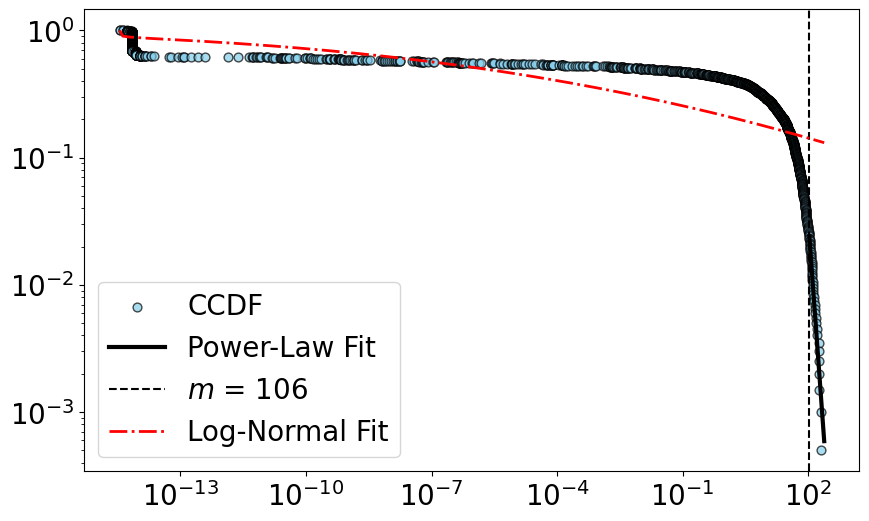

Power law exponent = 5.533082221337767
Power law minimum = 106.11607225726256


In [92]:
wealth = pd.read_sql_query(
    f"""
        SELECT deposits
        FROM 
            household_data
        WHERE
            time = {middle}
    ;
    """,
    con
)
# data 
data = wealth.to_numpy().reshape(1, -1)[0]
# power law fit results 
results = pl.Fit(data)
a, m = results.alpha, results.xmin
# complementary cdf 
plt.figure(figsize=(10,6))
# x values 
x = np.sort(data)
# complementary cdf (ccdf)
cdf = np.arange(1,len(data)+1)/(len(data))
ccdf = 1 - cdf
plt.scatter(x, ccdf, color='skyblue', edgecolors='k', alpha=0.7, s=40, label='CCDF')
# power law fit
# => rescale to start fit from cut off
index = np.where(x == m)[0][0]
rescale = ccdf[index]
power_law_fit = np.where(x >= m, np.power((m)/x,a-1)*rescale, np.nan)
plt.plot(x, power_law_fit, color='k', linewidth=3, label='Power-Law Fit')
# power law cut off (mF)
plt.axvline(m, color='k', linestyle='--', label=r'$m$'f' = {round(m)}') # type: ignore
# lognormal distribution
params = stats.lognorm.fit(data)
cdf = stats.lognorm.cdf(x, params[0], params[1], params[2])
plt.plot(x, 1 - cdf, color='r', linestyle='-.', linewidth=2, label='Log-Normal Fit')
# log-log axis
plt.loglog()
# legend
plt.legend(fontsize=20, loc='lower left')
# tick size
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.show()
print(f'Power law exponent = {a}')
print(f'Power law minimum = {m}')

### Banks

In [93]:
# bank data
banks = pd.read_sql_query(
    f"""
        SELECT *
        FROM 
            bank_data
    ;
    """,
    con
)
banks.describe()

,simulation,time,profits,loan_interest,equity,deposits,loans,bad_loans,expected_bad_loans,expected_bad_loans_ratio,reserves,reserve_ratio,capital_ratio,min_capital_ratio,market_share,degree
count,6000.0,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000
mean,0.0,300.500000,38.395290,0.014579,2559.905953,35156.941026,14768.236684,139.824600,165.370327,0.011292,22962.025443,0.583046,4.971917,0.071292,0.100000,103.769000
std,0.0,173.219276,104.837098,0.001302,5281.515229,52480.348974,37386.196634,1128.130457,967.873460,0.020807,45196.617519,0.543796,57.708199,0.020807,0.119388,71.539807
min,0.0,1.000000,-35.423766,0.012265,0.036059,172.120796,0.000000,0.000000,0.000000,0.000000,-233610.362836,-2.285038,-1.009806,0.060000,0.000000,0.000000
25%,0.0,150.750000,-0.133459,0.013809,69.891051,1639.704177,171.817059,0.000000,0.000000,0.000000,564.043288,0.372047,0.091546,0.060000,0.010009,28.000000
50%,0.0,300.500000,2.646199,0.014180,424.326364,10101.298392,1710.965839,0.000000,0.151620,0.000364,4101.361308,0.759377,0.172589,0.060364,0.063114,113.500000
75%,0.0,450.250000,25.536667,0.014921,1911.445164,44579.626207,10739.067023,0.000000,14.109035,0.012542,25681.749348,0.985569,0.668982,0.072542,0.145062,170.000000
max,0.0,600.000000,1205.676071,0.022562,41572.059402,263042.109574,459290.736834,41183.358820,25676.944109,0.156781,258105.802484,1.177051,3184.061957,0.216781,0.698012,222.000000


In [94]:
banks

,simulation,time,id,profits,loan_interest,equity,deposits,loans,bad_loans,expected_bad_loans,expected_bad_loans_ratio,reserves,reserve_ratio,capital_ratio,min_capital_ratio,market_share,degree
0,0,1,Bank: 0,0.492985,0.019680,14.080677,424.492308,220.800000,0.000000,0.000000,0.000000,217.772985,0.513020,0.063771,0.060000,0.115000,23.0
1,0,1,Bank: 1,0.259346,0.019647,7.939346,317.120000,124.800000,0.000000,0.000000,0.000000,200.259346,0.631494,0.063617,0.060000,0.065000,13.0
2,0,1,Bank: 2,0.423998,0.019896,12.239382,387.864615,192.000000,0.000000,0.000000,0.000000,208.103998,0.536538,0.063747,0.060000,0.100000,20.0
3,0,1,Bank: 3,0.671032,0.019631,18.984878,545.846154,297.600000,0.000000,0.000000,0.000000,267.231032,0.489572,0.063793,0.060000,0.155000,31.0
4,0,1,Bank: 4,0.423438,0.019511,12.238822,390.104615,192.000000,0.000000,0.000000,0.000000,210.343438,0.539198,0.063744,0.060000,0.100000,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,0,600,Bank: 5,333.835886,0.012707,24067.623659,185181.092007,155325.144212,116.149174,276.949353,0.001783,54039.720628,0.291821,0.155698,0.061783,0.173463,184.0
5996,0,600,Bank: 6,-10.288729,0.013509,5004.236957,210879.533924,10065.086435,4.326316,17.408643,0.001730,205823.010762,0.976022,0.497618,0.061730,0.011240,57.0
5997,0,600,Bank: 7,351.951311,0.013922,15825.175314,121743.042691,122997.145887,1053.219921,228.305098,0.001856,15624.292040,0.128338,0.137226,0.061856,0.137360,181.0
5998,0,600,Bank: 8,455.852278,0.012995,10337.147012,227973.891130,201400.617000,1876.526713,358.362900,0.001779,38786.947855,0.170138,0.060644,0.061779,0.224919,190.0


In [95]:
banks.loc[banks['time']==1]['loans'].sum()

1919.9999999999993

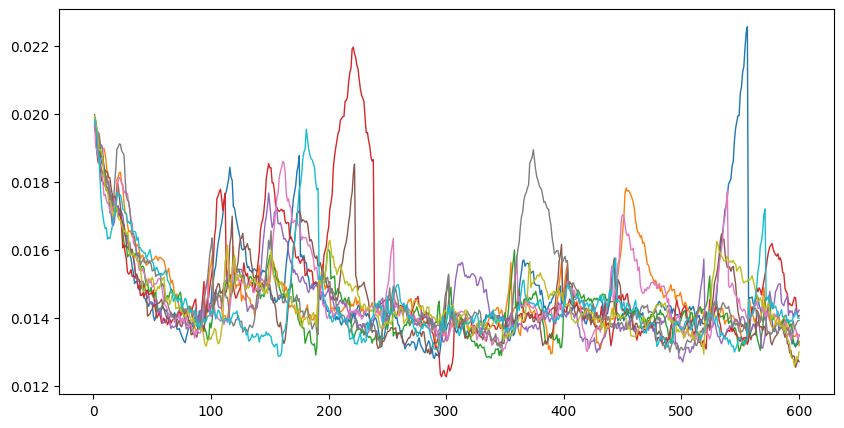

In [98]:
# interest rate
plt.figure(figsize=(10,5))
interest = pd.pivot_table(banks, values=['loan_interest'], index=['time'], columns=['id'])

for col in interest.columns:
    plt.plot(interest[col], linewidth=1)
    
plt.show()

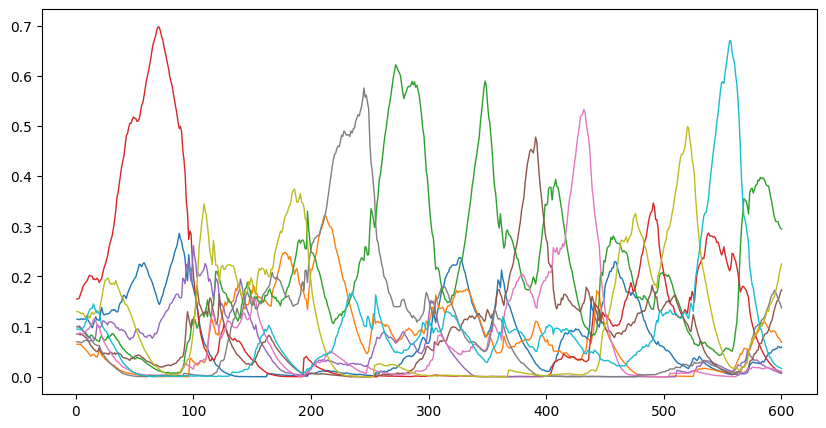

In [104]:
# bank market shares
plt.figure(figsize=(10,5))
market_shares = pd.pivot_table(banks, values=['market_share'], index=['time'], columns=['id'])

for col in market_shares.columns:
    plt.plot(market_shares[col], linewidth=1)
    
plt.show()

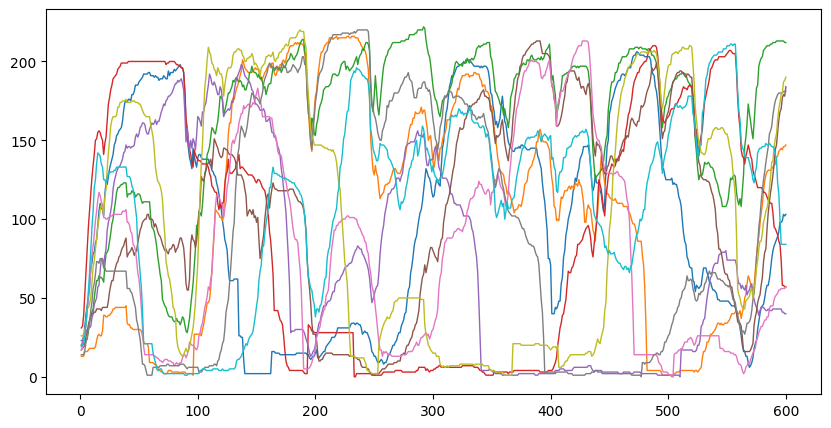

In [105]:
# bank degree 
plt.figure(figsize=(10,5))
degree = pd.pivot_table(banks, values=['degree'], index=['time'], columns=['id'])

for col in degree.columns:
    plt.plot(degree[col], linewidth=1)
    
plt.show()

Calculating best minimal value for power law fit


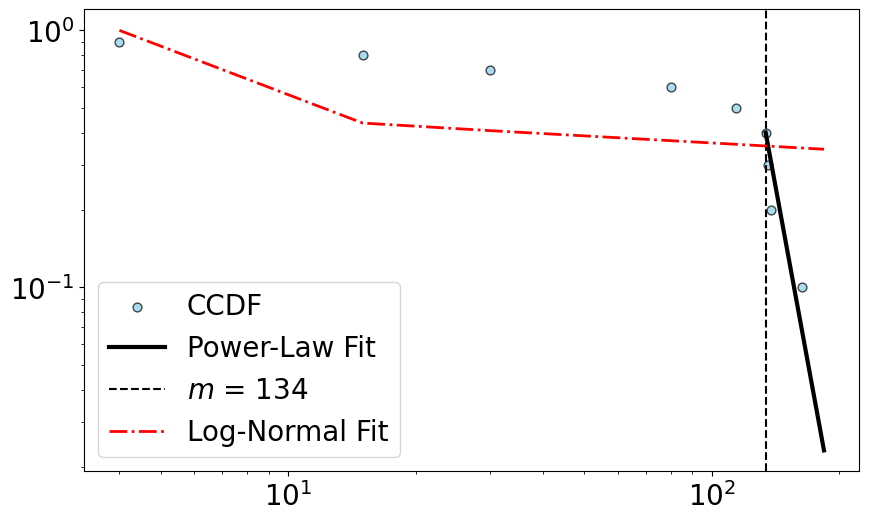

Power law exponent = 9.972869693022417
Power law minimum = 134.0
Distribution compare = (-0.7988631418161276, 0.12379863210383059)


C:\Users\Dylan\AppData\Roaming\Python\Python311\site-packages\powerlaw.py:1615: RuntimeWarning: invalid value encountered in divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


In [107]:
data = pd.read_sql_query(
    f"""
        SELECT degree
        FROM 
            bank_data
        WHERE 
            time = {middle}
    ;
    """,
    con
)
# data 
data = data.to_numpy().reshape(1, -1)[0]
# power law fit results 
results = pl.Fit(data)
a, m = results.alpha, results.xmin
# complementary cdf 
plt.figure(figsize=(10,6))
# x values 
x = np.sort(data)
# complementary cdf (ccdf)
cdf = np.arange(1,len(data)+1)/(len(data))
ccdf = 1 - cdf
plt.scatter(x, ccdf, color='skyblue', edgecolors='k', alpha=0.7, s=40, label='CCDF')
# power law fit
# => rescale to start fit from cut off
index = np.where(x == m)[0][0]
rescale = ccdf[index]
power_law_fit = np.where(x >= m, np.power((m)/x,a-1)*rescale, np.nan)
plt.plot(x, power_law_fit, color='k', linewidth=3, label='Power-Law Fit')
# power law cut off (mF)
plt.axvline(m, color='k', linestyle='--', label=r'$m$'f' = {round(m)}') # type: ignore
# lognormal distribution
params = stats.lognorm.fit(data)
cdf = stats.lognorm.cdf(x, params[0], params[1], params[2])
plt.plot(x, 1 - cdf, color='r', linestyle='-.', linewidth=2, label='Log-Normal Fit')
# log-log axis
plt.loglog()
# legend
plt.legend(fontsize=20, loc='lower left')
# tick size
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.show()
print(f'Power law exponent = {a}')
print(f'Power law minimum = {m}')
print(f"Distribution compare = {results.distribution_compare('power_law', 'lognormal')}")

Calculating best minimal value for power law fit


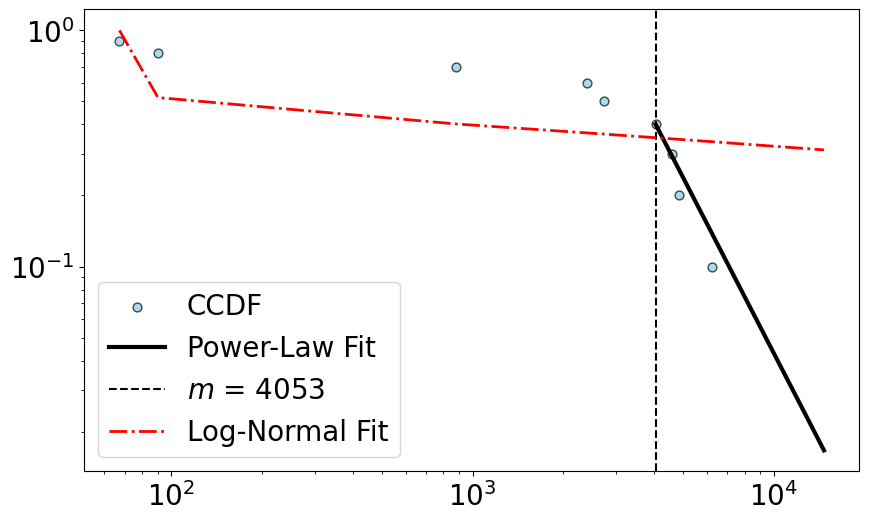

Power law exponent = 3.467409351578286
Power law minimum = 4053.332987902473
Distribution compare = (-0.7184037649510371, 0.24396230051310075)


'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


In [108]:
data = pd.read_sql_query(
    f"""
        SELECT loans
        FROM 
            bank_data
        WHERE
            time = {middle}
    ;
    """,
    con
)
# data 
data = data.to_numpy()[data>0].reshape(1, -1)[0]
# power law fit results 
results = pl.Fit(data)
a, m = results.alpha, results.xmin
# complementary cdf 
plt.figure(figsize=(10,6))
# x values 
x = np.sort(data)
# complementary cdf (ccdf)
cdf = np.arange(1,len(data)+1)/(len(data))
ccdf = 1 - cdf
plt.scatter(x, ccdf, color='skyblue', edgecolors='k', alpha=0.7, s=40, label='CCDF')
# power law fit
# => rescale to start fit from cut off
index = np.where(x == m)[0][0]
rescale = ccdf[index]
power_law_fit = np.where(x >= m, np.power((m)/x,a-1)*rescale, np.nan)
plt.plot(x, power_law_fit, color='k', linewidth=3, label='Power-Law Fit')
# power law cut off (mF)
plt.axvline(m, color='k', linestyle='--', label=r'$m$'f' = {round(m)}') # type: ignore
# lognormal distribution
params = stats.lognorm.fit(data)
cdf = stats.lognorm.cdf(x, params[0], params[1], params[2])
plt.plot(x, 1 - cdf, color='r', linestyle='-.', linewidth=2, label='Log-Normal Fit')
# log-log axis
plt.loglog()
# legend
plt.legend(fontsize=20, loc='lower left')
# tick size
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.show()
print(f'Power law exponent = {a}')
print(f'Power law minimum = {m}')
print(f"Distribution compare = {results.distribution_compare('power_law', 'lognormal')}")